In [1]:
# First of all, import packages for data cleaning and plotting 
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import math
import os

from functools import reduce   # to merge multiple dataframe

from scipy import stats # boxcox transform

import warnings
warnings.filterwarnings("ignore")   # to ignore wwarning message

# Read Original Data File

In [2]:
# set working directory
path = r'xxx'
os.chdir(path)
# Read dataset 'data.csv' and display basic description of this dataset
dataset = pd.read_csv('data.csv')

print('1) The number of rows and columns of this dataset: ' + str(dataset.shape))

print('2) The type of data for each column of this dataset: ', dataset.dtypes, sep='\n')

print('3) The description of this dataset: ', dataset.describe(), sep='\n')

1) The number of rows and columns of this dataset: (1460, 81)
2) The type of data for each column of this dataset: 
Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
                  ...   
BedroomAbvGr       int64
KitchenAbvGr       int64
KitchenQual       object
TotRmsAbvGrd       int64
Functiona

# BELOW are Answers for This Case Study

1) For each neighborhood, find the median sale price for homes 
   (a) Sold in 2006
   (b) Indoor square footage >= 2000 sf (excluding porches, garages, decks, and veneers)

In [3]:
# Filter the dataset to only have the house sold in 2006 to improve the efficiency of data manipulation
df2006 = dataset[dataset['YrSold'] == 2006].copy()
#print(dataset2006.head())
# Create two new colomns respectively 
# called 'PorchSF: Total porch square feet' 
# and 'IndoorSF: Indoor square feet'
# Assume: 
#        indoor square footage =
#                                Above grade living area square feet (GrLivArea)
#                                + Total square feet of basement area (TotalBsmtSF) 
#                                – porches (OpenProchSF+EnclosedPorch+3SsnPorch+ScreenPorch) 
#                                – garages (GarageArea) 
#                                – decks (WoodDeckSF) 
#                                – veneers (MasVnrArea) 

## Total porch square feet
df2006['PorchSF'] = df2006['OpenPorchSF'] + df2006['EnclosedPorch'] + df2006['3SsnPorch'] + df2006['ScreenPorch']
## Indoor square feet 
df2006['IndoorSF'] = df2006['GrLivArea'] + df2006['TotalBsmtSF'] \
                         - df2006['PorchSF'] \
                         - df2006['GarageArea'] \
                         - df2006['WoodDeckSF'] \
                         - df2006['MasVnrArea']

In [4]:
# Get a subset of this dataset with Indoor square feet being greater than or equal to 2000 sf 
# and containing only three columns for simplification
sub_df = df2006[df2006['IndoorSF']>=2000][['Neighborhood','SalePrice','IndoorSF']]
print('The number of rows and columns of this sub_dataset', sub_df.shape)
print('The number of unique values in the Neighborhood column of this sub_dataset', len(sub_df.Neighborhood.unique()))

The number of rows and columns of this sub_dataset (117, 3)
The number of unique values in the Neighborhood column of this sub_dataset 21


In [5]:
# Group 'sub_dataset' by the 'Neighborhood' column and get the median sale price for each group
Median_SalePrice_byNeighbor = sub_df.groupby(['Neighborhood'], as_index = False).agg({'SalePrice':'median'}).rename(columns={'SalePrice':'Median_SalePrice'})
Median_SalePrice_byNeighbor = Median_SalePrice_byNeighbor.sort_values('Median_SalePrice')
print(Median_SalePrice_byNeighbor)

   Neighborhood  Median_SalePrice
14        SWISU          129250.0
5       Edwards          136900.0
9         NAmes          145125.0
13      OldTown          148500.0
1       BrkSide          149000.0
7       MeadowV          151400.0
8       Mitchel          170000.0
15       Sawyer          170000.0
6       Gilbert          210950.0
0       Blmngtn          215000.0
3       CollgCr          217000.0
16      SawyerW          220000.0
4       Crawfor          223000.0
2       ClearCr          225000.0
10       NWAmes          235000.0
20      Veenker          270000.0
11      NoRidge          279000.0
17      Somerst          290000.0
12      NridgHt          328821.5
19       Timber          335000.0
18      StoneBr          361919.0


In [ ]:
# Median_SalePrice_byNeighbor.to_excel('MedianSalePrice.xlsx')

2) The seasonality of the local housing market

In [6]:
# First of all, copy dataset for question 2, and create a new column 'Date' combining 'MoSold' and 'YrSold'
q2_df = dataset.copy()
q2_df = q2_df.groupby(['Neighborhood']).apply(lambda x: x.sort_values(['YrSold','MoSold'])).reset_index(drop=True)
q2_df['Date'] = q2_df['MoSold'].map(str)+ '-' + q2_df['YrSold'].map(str)
q2_df['Date'] = pd.to_datetime(q2_df['Date'], format='%m-%Y').dt.strftime('%m-%Y')
print(q2_df[['YrSold','MoSold','Date','Neighborhood','SalePrice']].head(10))

   YrSold  MoSold     Date Neighborhood  SalePrice
0    2006       3  03-2006      Blmngtn     167240
1    2006       4  04-2006      Blmngtn     213490
2    2006       5  05-2006      Blmngtn     178740
3    2006       5  05-2006      Blmngtn     215000
4    2006      10  10-2006      Blmngtn     234000
5    2006      10  10-2006      Blmngtn     264561
6    2006      10  10-2006      Blmngtn     246578
7    2007       2  02-2007      Blmngtn     194201
8    2007       6  06-2007      Blmngtn     172500
9    2008       3  03-2008      Blmngtn     159895


2.1) Time Series Analysis

In [7]:
# Get dataset for time series analysis
grouped_ts = q2_df.groupby(['Date','YrSold','MoSold']).agg({"SalePrice": [min, max, 'mean','median']})
grouped_ts.columns = ["_".join(x) for x in grouped_ts.columns.ravel()]

df_ts = grouped_ts.reset_index().sort_values(['YrSold','MoSold'])
# Check missing values 
print('1) Check Missing Values: ', df_ts.isnull().any(),sep = '\n')

print('2) Demo of Sale Price Series: ',df_ts.head(), sep = '\n')



1) Check Missing Values: 
Date                False
YrSold              False
MoSold              False
SalePrice_min       False
SalePrice_max       False
SalePrice_mean      False
SalePrice_median    False
dtype: bool
2) Demo of Sale Price Series: 
       Date  YrSold  MoSold  SalePrice_min  SalePrice_max  SalePrice_mean  \
0   01-2006    2006       1         105000         423000   201090.000000   
5   02-2006    2006       2         140000         230000   194322.222222   
10  03-2006    2006       3          52500         369900   184982.200000   
15  04-2006    2006       4          79000         437154   174312.814815   
20  05-2006    2006       5          81000         312500   158928.289474   

    SalePrice_median  
0           176700.0  
5           192500.0  
10          162900.0  
15          145250.0  
20          156950.0  


<Figure size 432x288 with 0 Axes>

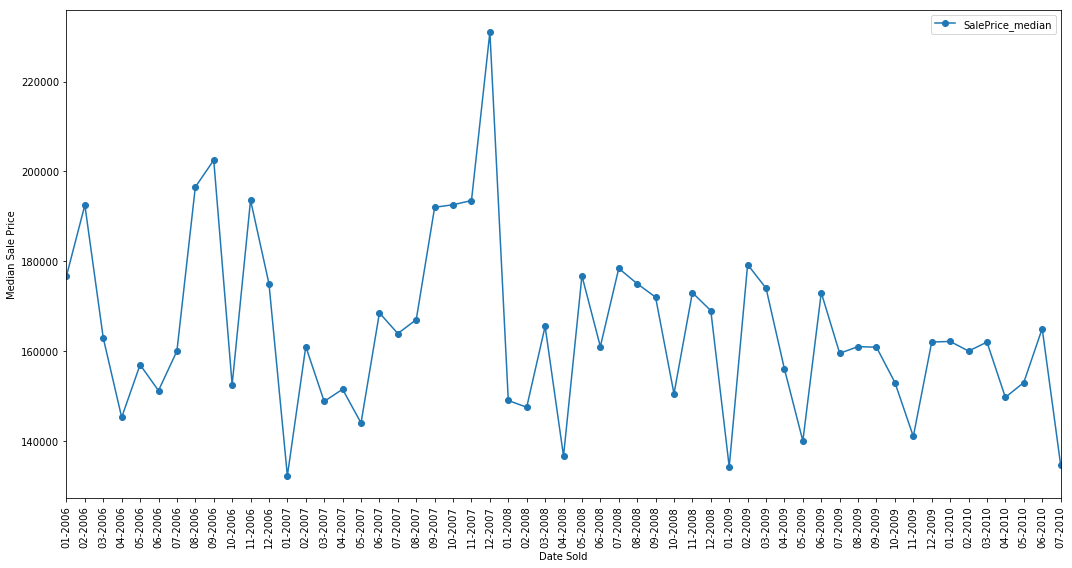

In [8]:
plt.figure()
df_ts.plot(x = 'Date', y = 'SalePrice_median', style='o-',figsize=(15,8))
plt.xlabel('Date Sold')
plt.ylabel('Median Sale Price')
plt.xticks(np.arange(len(df_ts['Date'])),df_ts.Date,rotation=90)
plt.tight_layout()
plt.savefig('df_ts.png')
plt.show()

Use Inter-Quantile Range (IQR) to check for outliers in the data of median sale price

In [ ]:
# function to get quantiles 
def q1(x):
    return x.quantile(0.25)

def q3(x):
    return x.quantile(0.75)

# function to check outliers for 1 and 2 methods
def outlierCheck(row,name1,name2):
    if row[name1] > 0:
        return 'True'
    elif row[name2] > 0:
        return 'True'
    else:
        return 'False'

In [ ]:
df11_ts = df_ts[['Date','SalePrice_median']].copy()
stat_df = df11_ts.agg({'SalePrice_median':[q1,q3]})
IQR = (stat_df.loc['q3'] - stat_df.loc['q1']).values[0]
parameter = 1.5
lower_bound = stat_df.loc['q1'].values[0] - IQR*parameter
upper_bound = stat_df.loc['q3'].values[0] + IQR*parameter
print(lower_bound,upper_bound, sep = '\n')
df11_ts['LowerDiff'] = lower_bound - df11_ts['SalePrice_median'] 
df11_ts['UpperDiff'] = df11_ts['SalePrice_median'] - upper_bound
df11_ts['outlier'] = df11_ts.apply(lambda row: outlierCheck (row,'LowerDiff','UpperDiff'),axis=1)
df11_ts[df11_ts['outlier'] == 'True']

In [ ]:
# # Replace outlier (value for date 2007-12) by observation last year in the same month
# df_ts_imputed = df_ts.copy()
# # print(df_ts_imputed[df_ts_imputed['Date']=='12-2007'])
# df_ts_imputed['Date'] = pd.to_datetime(df_ts_imputed['Date'])
# df_ts_imputed.set_index('Date', inplace=True)
# print(df_ts_imputed.loc['2007-12-01','SalePrice_median'])

# df_ts_imputed.loc['2007-12-01','SalePrice_median'] = (df_ts_imputed.loc['2006-12-01','SalePrice_median'])
# print(df_ts_imputed.loc['2007-12-01','SalePrice_median'])

In [18]:
df_ts_imputed = df_ts.copy()
df_ts_imputed['Date'] = pd.to_datetime(df_ts_imputed['Date'])
df_ts_imputed.set_index('Date', inplace=True)

There are many other methods that could be used to detect anomaly:

(1) Clustering-Based Anomaly Detection : k-means algorithm
One way to think about the k-means model is that it places a circle (or, in higher dimensions, a hyper-sphere) at the center of each cluster, with a radius defined by the most distant point in the cluster.
Alternatively, we could use 
Gaussian Mixture Model (GMM), which allows each cluster to be modeled as an ellipse with arbitrary orientation.
Fundamentally it is an algorithm for density estimation. 
That is to say, the result of a GMM fit to some data is technically not a clustering model, but a generative probabilistic model describing the distribution of the data.

(2) These two disadvantages of k-means:
its lack of flexibility in cluster shape and lack of probabilistic cluster assignment

In [10]:
from sklearn.cluster import KMeans

In [11]:
df_ts_imputed = df_ts.copy().set_index('Date')
df_check_outlier = df_ts_imputed[['SalePrice_median']]

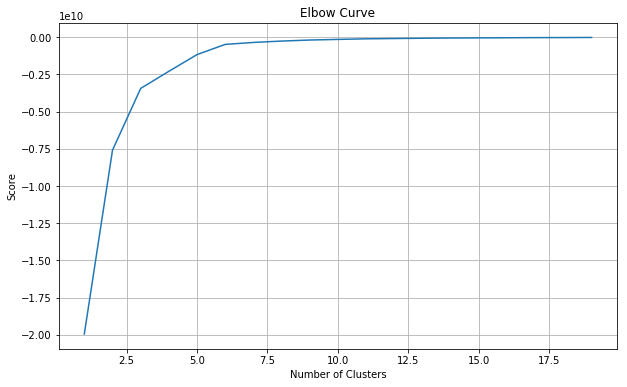

In [12]:
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i).fit(df_check_outlier) for i in n_cluster]
scores = [kmeans[i].score(df_check_outlier) for i in range(len(kmeans))]
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(n_cluster, scores)
ax.grid(True)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

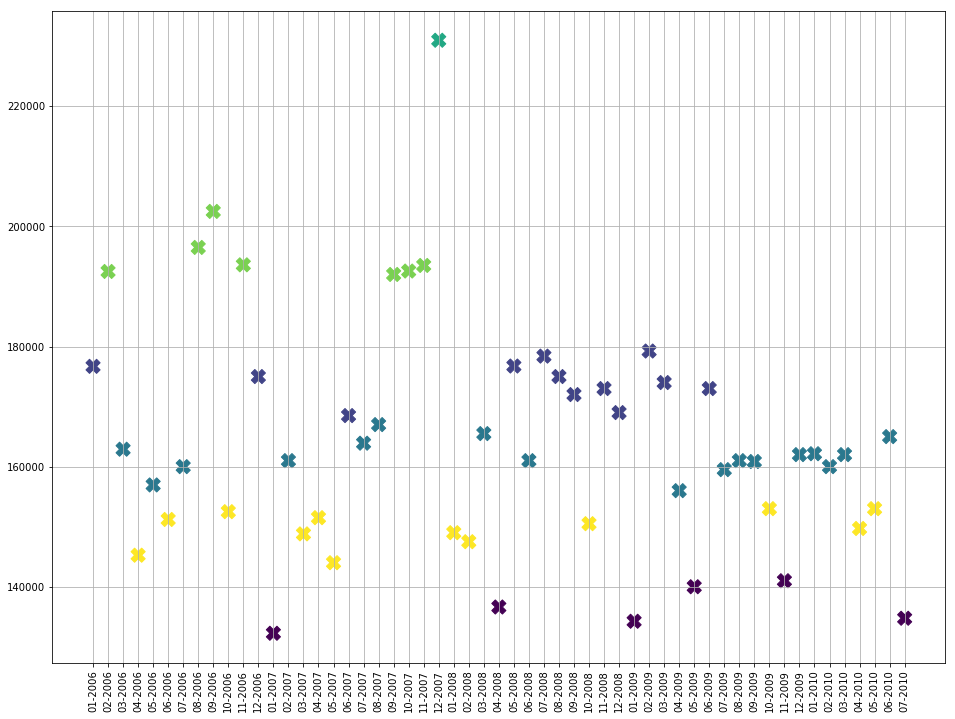

In [13]:
km = KMeans(n_clusters=6)
km.fit(df_check_outlier)
km.predict(df_check_outlier)
y_kmeans = km.predict(df_check_outlier)
labels = km.labels_
# print('Clustering Labels: ' , labels, sep='\n')
centroids = km.cluster_centers_
# print('centroids: ' , centroids, sep='\n')

plt.figure(figsize=(16,12))
plt.scatter(df_check_outlier.index,df_check_outlier['SalePrice_median'], c=labels.astype(np.float), marker='X',s=200)
plt.xticks(rotation=90)

plt.grid(True)
plt.savefig('Kmeans_Outliers.png')
plt.show()

In [14]:
label_ls = []
center_ls = []

for i in range(len(df_check_outlier)):
    date = df_check_outlier.index[i]
    x_cValue = km.cluster_centers_[km.labels_[i]]
    label_ls.append(km.labels_[i])
    center_ls.append(x_cValue[0])
    
cluster_df = pd.DataFrame({'Cluster_Label': label_ls, 'Cluster_Centroid': center_ls},index = df_check_outlier.index)
full_df = pd.concat([df_check_outlier , cluster_df],axis=1)

In [ ]:
# import seaborn as sns
# sns.set_style("whitegrid")
# plot_cluster = sns.lmplot(data = full_df.reset_index(), x='Date', y='SalePrice_median', hue='Cluster_Label', 
#                    fit_reg=False, legend=True, legend_out=True,aspect=30/10)
# plot_cluster.set_xticklabels(rotation=90)

In [ ]:
# def DistanceByCenter(data,model):
#     distance = pd.Series()
#     for i in range(len(df_check_outlier)):
#         date = df_check_outlier.index[i]
#         x_data = np.array(df_check_outlier.loc[date])
#         x_cValue = km.cluster_centers_[km.labels_[i]]
#         distance.set_value(i,abs(float(float(x_data[0])- float(x_cValue[0]))))
#     return distance

# outliers_fraction = 0.01

# # # get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
# distance = DistanceByCenter(df_check_outlier, km)
# print(distance)
# number_of_outliers = int(math.ceil(outliers_fraction*len(distance)))
# threshold = distance.nlargest(number_of_outliers).min()
# print(threshold)
# # anomaly1 contain the anomaly result of the above method Cluster (0:normal, 1:anomaly) 
# df_check_outlier['anomaly1'] = (distance >= threshold).astype(int)
# print(df_check_outlier)

(1) Isolation Forests For Anomaly Detection
It detects anomalies purely based on the concept of isolation without employing any distance or density measure —fundamentally different from all existing methods

<class 'pandas.core.series.Series'>


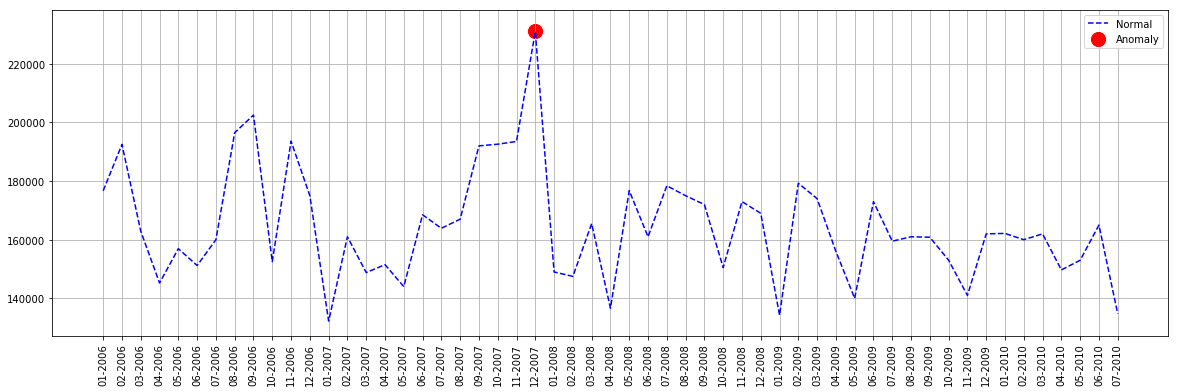

In [15]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings('ignore')
data = df_check_outlier[['SalePrice_median']]
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# train isolation forest
outliers_fraction = 0.01
model =  IsolationForest(contamination=outliers_fraction)
model.fit(data) 
df_check_outlier['anomaly_ISOF'] = model.predict(data)
# visualization
fig, ax = plt.subplots(figsize=(20,6))

a = df_check_outlier.loc[df_check_outlier['anomaly_ISOF'] == -1, 'SalePrice_median'] #anomaly
print(type(a))
ax.plot(df_check_outlier.index, df_check_outlier['SalePrice_median'], color='blue', label = 'Normal',linestyle= '--')
ax.scatter(a.index,a, color='red', label = 'Anomaly', s=200)
plt.xticks(rotation=90)
plt.grid(True)
plt.legend()
plt.savefig('IsolationForest_Outliers.png')
plt.show()

(3) OneClassSVM
The idea of SVM for anomaly detection is to find a function that is positive for regions with high density of points, and negative for small densities.

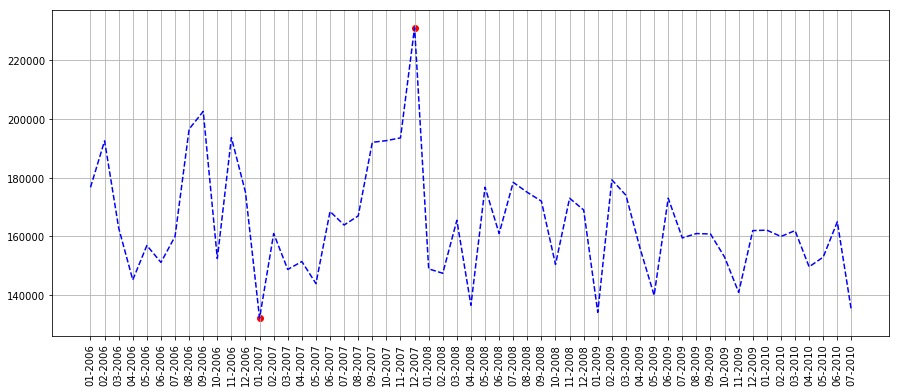

In [16]:
from sklearn.svm import OneClassSVM
data = df_check_outlier[['SalePrice_median']]
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# train oneclassSVM 
model = OneClassSVM(nu=0.04, kernel="rbf", gamma=0.01)
model.fit(data)
df_check_outlier['anomaly_SVM'] = model.predict(data)

fig, ax = plt.subplots(figsize=(15,6))
a = df_check_outlier.loc[df_check_outlier['anomaly_SVM'] == -1, 'SalePrice_median'] #anomaly

ax.plot(df_check_outlier.index, df_check_outlier['SalePrice_median'], color='blue',linestyle= '--')
ax.scatter(a.index,a, color='red')
plt.grid(True)
plt.xticks(rotation=90)
plt.show();

(3) EllipticEnvelope
Gaussian distribution is also called normal distribution. We will be using the Gaussian distribution to develop an anomaly detection algorithm, that is, we’ll assume that our data are normally distributed. This’s an assumption that cannot hold true for all data sets, yet when it does, it proves an effective method for spotting outliers.
Scikit-Learn’s covariance.EllipticEnvelope is a function that tries to figure out the key parameters of our data’s general distribution by assuming that our entire data is an expression of an underlying multivariate Gaussian distribution

ABOVE are methods for outlier detection

1. Portential issue: 
 (1) this series is not long enough
 (2) might exist outliers
2. Also we could try other models such as Simple Exponential Smoothing (SES) and Holt Winter’s Exponential Smoothing (HWES)
to find one with a better performance based on some evaluation metrics
Mean Absolute Percentage Error (MAPE)
Mean Error (ME)
Mean Absolute Error (MAE)
Mean Percentage Error (MPE)
Root Mean Squared Error (RMSE)
Lag 1 Autocorrelation of Error (ACF1)
Correlation between the Actual and the Forecast (corr)
Min-Max Error (minmax)
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1

In [ ]:
# In order to stabilize the variance,
# Add a new column for Log transformation
df_ts_imputed['Log_SalePrice_median'] = np.log(df_ts_imputed['SalePrice_median'])

# Add a new column for Boxcox transformation 
df_ts_imputed['BC_SalePrice_median'],fitted_lambda = stats.boxcox(df_ts_imputed['SalePrice_median'])
print('BoxCox Transformation Parameter: ', fitted_lambda)

In [ ]:
df_Blmngtn = df1[df1['Neighborhood']=='Blmngtn'][['Date','SalePrice_median']]
df_Blmngtn.reset_index(drop=True, inplace=True)
print(df_Blmngtn)
plt.figure()
df_Blmngtn.plot(x='Date',y='SalePrice_median', style='o-',title='Bloomington Height')
plt.xlabel('Date Sold')


In [ ]:
# Plot time series data
fig, ax = plt.subplots(3, figsize=(15,15))
df_ts_imputed.plot(y ='SalePrice_median', use_index=True, style='o-', ax=ax[0] ,legend=False)
ax[0].set_title('Median Sale Price')
ax[0].set_xlabel('Date Sold')

df_ts_imputed.plot(y ='Log_SalePrice_median', use_index=True, style='o-', ax=ax[1] , legend=False)
ax[1].set_title('Median Sale Price - Log Transform')
ax[1].set_xlabel('Date Sold')

df_ts_imputed.plot( y ='BC_SalePrice_median', use_index=True, style='o-', ax=ax[2] , legend=False)
ax[2].set_title('Median Sale Price - Boxcox Transform')
ax[2].set_xlabel('Date Sold')

plt.show()
# fig.savefig('ts_data.png')

In [19]:
# Seasonal decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

# Multiplicative Decomposition 
result_mul = seasonal_decompose(df_ts_imputed['SalePrice_median'], model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(df_ts_imputed['SalePrice_median'], model='additive', extrapolate_trend='freq')

<Figure size 432x288 with 0 Axes>

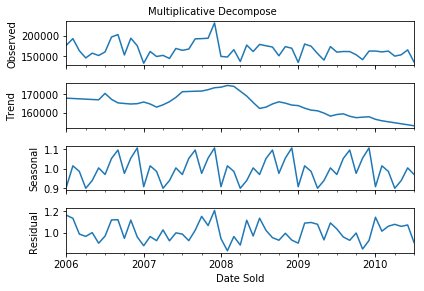

In [20]:
# Plot multiplicative decomposition

plt.figure()
result_mul.plot()

plt.suptitle('Multiplicative Decompose', ha = 'center', va = 'top', y=1.0, fontsize=10)
plt.xlabel('Date Sold')
plt.tight_layout()

# Save figure before show
# plt.savefig('Multiplicative_Decompose.png')
plt.show()

<Figure size 432x288 with 0 Axes>

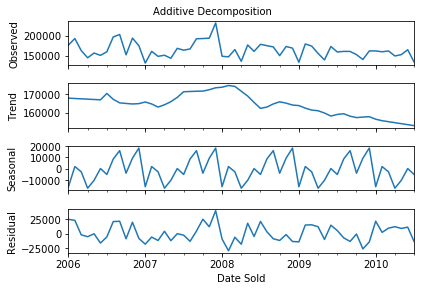

In [22]:
# Plot Additive decomposition
plt.figure()
result_add.plot()

plt.suptitle('Additive Decomposition', ha = 'center', va = 'top', y=1.0, fontsize=10)
plt.xlabel('Date Sold')
plt.tight_layout()

# Save figure before show
# plt.savefig("Additive_Decompose.png")
plt.show()

The plot above clearly shows that the sale price series has obvious seasonality.


Next let's start this forecasting process by statistical test for stationarity

Stationarity is a property of a time series. A stationary series is one where the values of the series is not a function of time.
That is, the statistical properties of the series like mean, variance and autocorrelation are constant over time. Autocorrelation of the series is that the correlation of the series with its previous values.

1) There are multiple implementations of Unit Root tests like:

(1.1) Augmented Dickey Fuller test (ADF Test) (It has an alternate hypothesis of linear or difference stationary)
(1.2) Kwiatkowski-Phillips-Schmidt-Shin – KPSS test (trend stationary)
(1.3) Philips Perron test (PP Test)

The most commonly used is the ADF test, where the null hypothesis is the time series possesses a unit root and is non-stationary. So, if the P-Value in ADF test is less than the significance level (0.05), you reject the null hypothesis.
The KPSS test, on the other hand, is used to test for trend stationarity. The null hypothesis and the P-Value interpretation is just the opposite of ADF test.

If the series is not stationary, we could 
(a) Differencing the Series (once or more)
(b) Take the log of the series
(c) Take the nth root of the series
(d) Combination of the above

In [23]:
from statsmodels.tsa.stattools import adfuller, kpss
# ADF Test
# H0: Not stationary 
result = adfuller(df_ts_imputed.SalePrice_median, autolag='AIC')
print(f'ADF Statistic: {result[0]}') # The more negative this statistic, the more likely we are to reject H0, vice versa.
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'{key}, {value}')    # If the test statistic is less than the critical value, we can reject H0

# KPSS Test
# H0: The process is trend stationary
result = kpss(df_ts_imputed.SalePrice_median, regression='c')
print('\nKPSS Statistic: %f' % result[0])  # If the test statistic is greater than the critical value, we reject H0
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'{key}, {value}')
    
# From the test results, we can see, this series is stationary

ADF Statistic: -5.7566025969787
p-value: 5.800323918078076e-07
Critial Values:
1%, -3.55770911573439
Critial Values:
5%, -2.9167703434435808
Critial Values:
10%, -2.59622219478738

KPSS Statistic: 0.383195
p-value: 0.084399
Critial Values:
10%, 0.347
Critial Values:
5%, 0.463
Critial Values:
2.5%, 0.574
Critial Values:
1%, 0.739


Case 1: Both tests conclude that the series is not stationary -> series is not stationary
Case 2: Both tests conclude that the series is stationary -> series is stationary
Case 3: KPSS = stationary and ADF = not stationary  -> trend stationary, remove the trend to make series strict stationary
Case 4: KPSS = not stationary and ADF = stationary -> difference stationary, use differencing to make series stationary

(1) Partial autocorrelation can be imagined as the correlation between the series and its lag, after excluding the contributions from the intermediate lags. So, PACF sort of conveys the pure correlation between a lag and the series. That way, you will know if that lag is needed in the AR term or not


In [32]:
# Data Preprocessing (the frequency of the series)
X = df_ts_imputed[['SalePrice_median']]
X.index = pd.DatetimeIndex(X.index.values,
                               freq=X.index.inferred_freq)


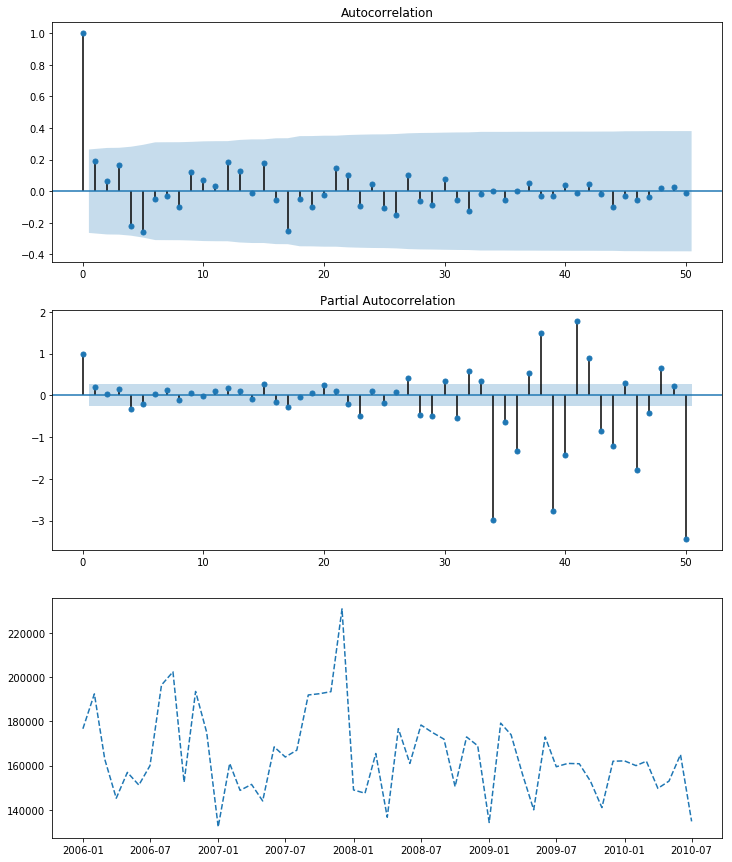

In [25]:
# Plot ACF and PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(3, figsize=(12,15))

ax[0] = plot_acf(X, ax=ax[0],lags=50)
ax[1] = plot_pacf(X, ax=ax[1],lags=50)
ax[2].plot(X,linestyle= '--')

Time Series Methods: Moving Average, Simple Exponential Smoothing, Holt’s Linear Trend method, Holt-Winters Method

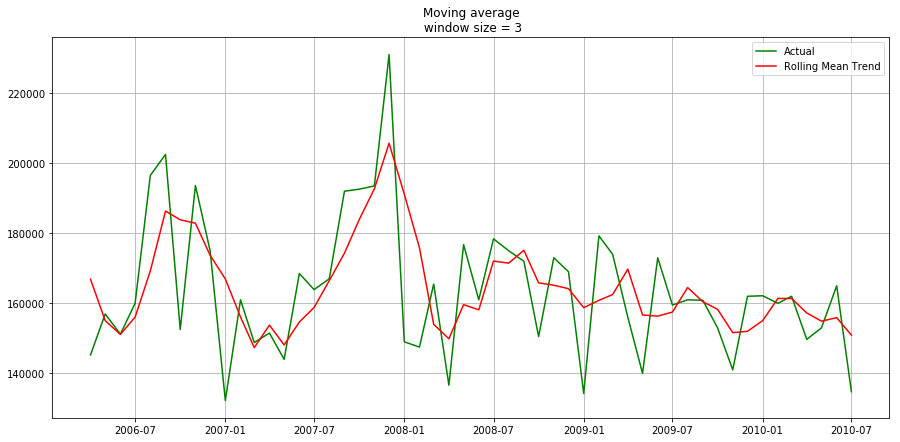

In [26]:
# Moving Average
n = 3
X['MA{}'.format(str(n))] = X['SalePrice_median'].rolling(n).mean()
# Chart
plt.figure(figsize=(15, 7))
plt.title("Moving average\n window size = {}".format(n))
plt.plot(X.SalePrice_median[n:], "g", label = "Actual")
plt.plot(X.MA3[n:], "red", label="Rolling Mean Trend")
plt.grid(True)
plt.legend(loc='best')
plt.show()

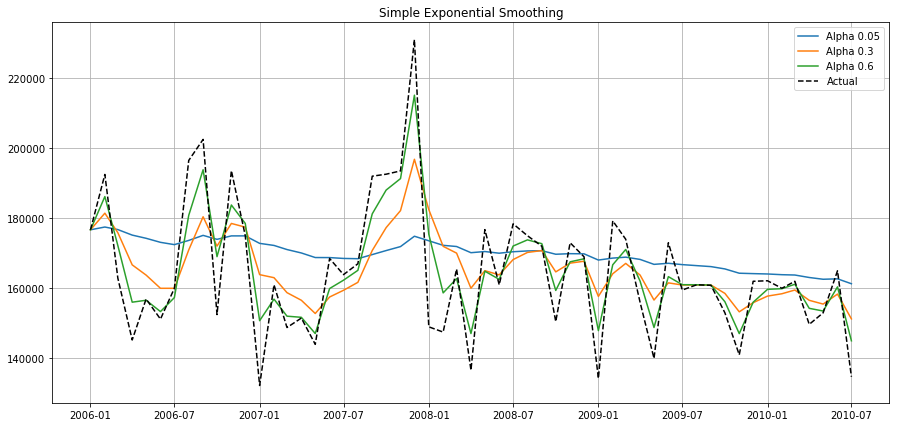

In [27]:
# Simple Exponential Smoothing: few data points, Irregular data, No seasonality or trend
def exponential_smoothing(data,alpha):
    result = [data[0]] # first value is same as series
    for n in range(1, len(data)):
        result.append(alpha * data[n] + (1 - alpha) * result[n-1])
    result1 = pd.DataFrame(result,index=data.index, columns = ['SES']) 
    return result1

alphas = [0.05, 0.3, 0.6]
plt.figure(figsize=(15, 7))
for alpha in alphas:
    plt.plot(exponential_smoothing(X.SalePrice_median,alpha), label='Alpha {}'.format(alpha))
plt.plot(X.SalePrice_median, 'black',linestyle = '--', label = "Actual")
plt.legend(loc='best')
plt.axis('tight')
plt.title('Simple Exponential Smoothing')
plt.grid(True)
plt.show()

In [28]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

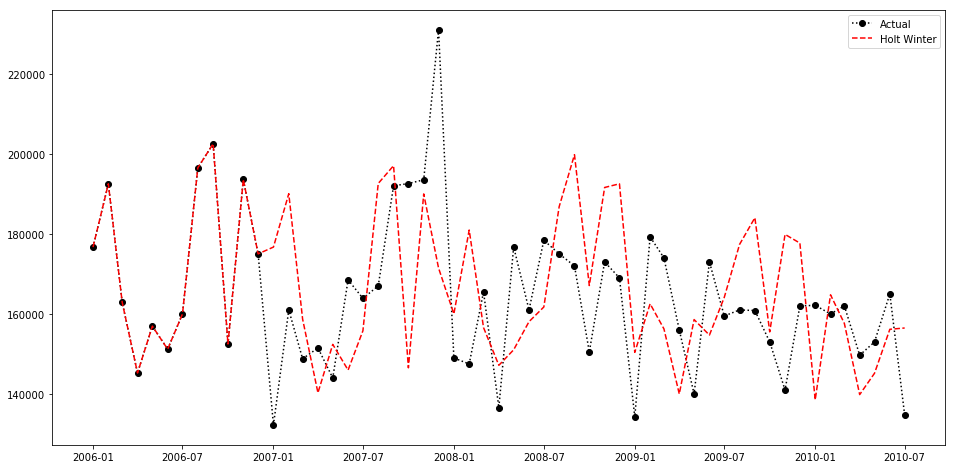

In [29]:
# Holt's Linear Smoothing: Trend in data, No seasonality.
fit1 = Holt(np.asarray(X['SalePrice_median'])).fit(smoothing_level = 0.3,smoothing_slope = 0.1)
y_hat_avg1 = pd.DataFrame(fit1.fittedvalues,index=X.index, columns = ['holt_linear'])

fit2 = ExponentialSmoothing(np.asarray(X['SalePrice_median']) ,seasonal_periods=12 ,trend='add', seasonal='add',).fit()
y_hat_avg2 = pd.DataFrame(fit2.fittedvalues, index= X.index, columns = ['holt_winter'])

plt.figure(figsize=(16,8))
plt.plot(X['SalePrice_median'],'black',linestyle = ':', marker="o",label='Actual')
# plt.plot(y_hat_avg1['holt_linear'], label='Holt linear')
plt.plot(y_hat_avg2['holt_winter'],'red' ,label='Holt Winter',linestyle = '--')
plt.legend(loc='best')
plt.savefig('holt_winter.png')
plt.show()


In [ ]:
fit1.forecast(9)
fit2.forecast(9)

In [ ]:
df = pd.DataFrame(np.c_[X['SalePrice_median'], fit2.level, fit2.slope, fit2.season, fit2.fittedvalues],
                  columns=['Obs','level','trend','seasonal','yhat'],index=X.index)
print(df.tail())

In [ ]:
# Set up parameter combinations for grid search
# import itertools
# p = d = q = range(0, 2)
# pdq = list(itertools.product(p, d, q))
# seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
# print(pdq,seasonal_pdq,sep='\n')

In [30]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# SARIMAX is an extension of the SARIMA model that also includes the modeling of exogenous variables

from sklearn.metrics import mean_squared_error
import pmdarima as pm

In [ ]:
# Split the dataset to be training and testing sets
train_size = int(len(X) * 0.85)
train, test = X.iloc[0:train_size,:], X.iloc[train_size:,:]

In [ ]:
# Use grid search by setting different (p,d,q)X(P,D,Q,m) combinations to find a better SARIMA model
# def evaluate_sarima_model(X, arima_order, sarima_order):
#     # prepare training dataset
#     train_size = int(len(X) * 0.8)
#     train, test = X[0:train_size], X[train_size:]
#     # make predictions
#     predictions = list()
#     for t in range(len(test)):
#         model = SARIMAX(train, order=arima_order, seasonal_order=sarima_order, enforce_invertibility=False, enforce_stationarity=False)
#         model_fit = model.fit(disp=0)
#         yhat = model_fit.forecast()[0]
#         predictions.append(yhat)
#     # calculate out of sample error
#     error = mean_squared_error(test, predictions)
#     return error

# # evaluate combinations of (p, d, q)X(p,d,q,m) values for a SARIMA model
# m=12 
# def evaluate_models(dataset, p_values, d_values, q_values):
#     best_score, best_cfg = float("inf"), None
#     for p in p_values:
#         for d in d_values:
#             for q in q_values:
#                 order = (p,d,q), order_s =(p,d,q,m) 
#                 try:
#                     mse = evaluate_sarima_model(dataset, order,order_s)
#                     if mse < best_score:
#                         best_score, best_param1, best_param2 = mse, order,order_s
#                     print('SARIMAX: %s x %s, MSE=%.3f' % (best_param1, best_param2,best_score))
#                 except:
#                     continue
#     print('Best SARIMA: %s x %s, MSE=%.3f' % (best_param1, best_param2,best_score)))


In [33]:
# Seasonal auto-arima to select a parameter combination with smallest AIC
auto_arima_model = pm.auto_arima(X, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=12,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # Seasonality
                      start_P=0, 
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(auto_arima_model.summary())

Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=986.570, BIC=991.783, Fit time=0.092 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=993.127, BIC=996.602, Fit time=0.012 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=986.186, BIC=993.137, Fit time=0.153 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=980.254, BIC=987.205, Fit time=0.141 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=978.212, BIC=986.900, Fit time=0.301 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 0, 12); AIC=985.275, BIC=992.226, Fit time=0.114 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=987.804, BIC=993.017, Fit time=0.036 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=979.7

In [ ]:
# Fit all the data and get fittedValues for all observations
# auto_arima_model_fit = auto_arima_model.fit(X)
# predicted = auto_arima_model_fit.predict_in_sample(X)
# future_forecast = pd.DataFrame(predicted,index = X.index,columns=['prediction'])
# df_forecast = pd.concat([X,future_forecast],axis=1)

#-----------------------------------------------------------------------------
# Fit the model using the training set and predict for testing set
auto_arima_model_fit = auto_arima_model.fit(train)

# future prediction for testing set
predicted_test = auto_arima_model_fit.predict(len(test))
predicted_test_df = pd.DataFrame(predicted_test,index = test.index,columns=['prediction'])
test_full_df = pd.concat([test,predicted_test_df],axis=1)
print(test_full_df.head())

# In sample prediction for training set
predicted_train = auto_arima_model_fit.predict_in_sample(train)
predicted_train_df = pd.DataFrame(predicted_train,index = train.index,columns=['prediction'])
train_full_df = pd.concat([train,predicted_train_df],axis=1)
print(train_full_df.head())

#
# frames = [train_full_df, test_full_df]
# result = pd.concat(frames)
result_df = train_full_df.append(test_full_df) 
print(result_df.head())


In [ ]:
# Auto-ARIMA using full dataset
# plt.figure(figsize=(16,8))
# plt.plot(df_forecast['SalePrice_median'][1:],'black',linestyle = ':', marker="o",label='Actual')
# plt.plot(df_forecast['prediction'][1:],'red' ,label='Auto-ARIMA',linestyle = '--')
# plt.legend(loc='best')
# plt.savefig('auto_arima.png')
# plt.show()

In [ ]:
# Auto-ARIMA by training and testing set
plt.figure(figsize=(16,8))
plt.plot(result_df['SalePrice_median'][1:],'black',linestyle = ':', marker="o",label='Actual')
plt.plot(result_df['prediction'][1:],'red' ,label='Auto-ARIMA',linestyle = '--')
plt.legend(loc='best')
plt.savefig('auto_arima.png')
plt.show()

In [ ]:
# # we can set up couple of parameter combinations for SARIMAX in 'statsmodels' package
# # and select a model with a smaller AIC or other metrics 
# sarima_model = SARIMAX(train, order=(1, 2, 1), seasonal_order=(1, 1, 0, 12), 
#                        enforce_invertibility=False, enforce_stationarity=False,trend='c')
# sarima_model_fit = sarima_model.fit()
# yhat_SARIMA = sarima_model_fit.forecast(11, alpha=0.05)
# # or equally use predict with time range
# # yhat_SARIMA = model_fit.predict(start="2009-09-01", end="2010-07-01", dynamic=True)
# sarima_model_fit.summary()

In [ ]:
# # SARIMA model
# # Plot training set, testing set and predicted yhat for testing set
# plt.figure(figsize=(16,8))
# plt.plot(train, label='Train')
# plt.plot(sarima_model_fit.fittedvalues,label='FittedValue')
# plt.plot(test, label='Test')
# plt.plot(yhat_SARIMA, label='SARIMA')
# plt.legend(loc='best')
# plt.show()

In [ ]:
# result_df['residuals'] = result_df['SalePrice_median'] - result_df['prediction']

# fig, ax = plt.subplots(3, figsize=(12,15))

# ax[0] = plot_acf(result_df.residuals, ax=ax[0])
# ax[1] = plot_pacf(result_df.residuals, ax=ax[1])
# ax[2].plot(result_df.residuals)

In [ ]:
# # sarima model residuals diagnostics
# sarima_model_fit.plot_diagnostics(figsize=(17,10))
# plt.show()

2.2) Look at the Regional Markets

In [35]:
# Group the dataset by neighborhood and date sold
grouped = q2_df.groupby(['Neighborhood','Date','YrSold','MoSold']).agg({"SalePrice": [min, max, 'mean','median']})
grouped.columns = ["_".join(x) for x in grouped.columns.ravel()]

df = grouped.reset_index().sort_values(['Neighborhood','YrSold','MoSold'])
df1 = df[['Neighborhood','Date','SalePrice_min','SalePrice_max','SalePrice_mean','SalePrice_median']]

In [37]:
# The number of rows for the plot below
n_rows = math.ceil(df1.groupby('Neighborhood').ngroups/2)
# print(n_rows)

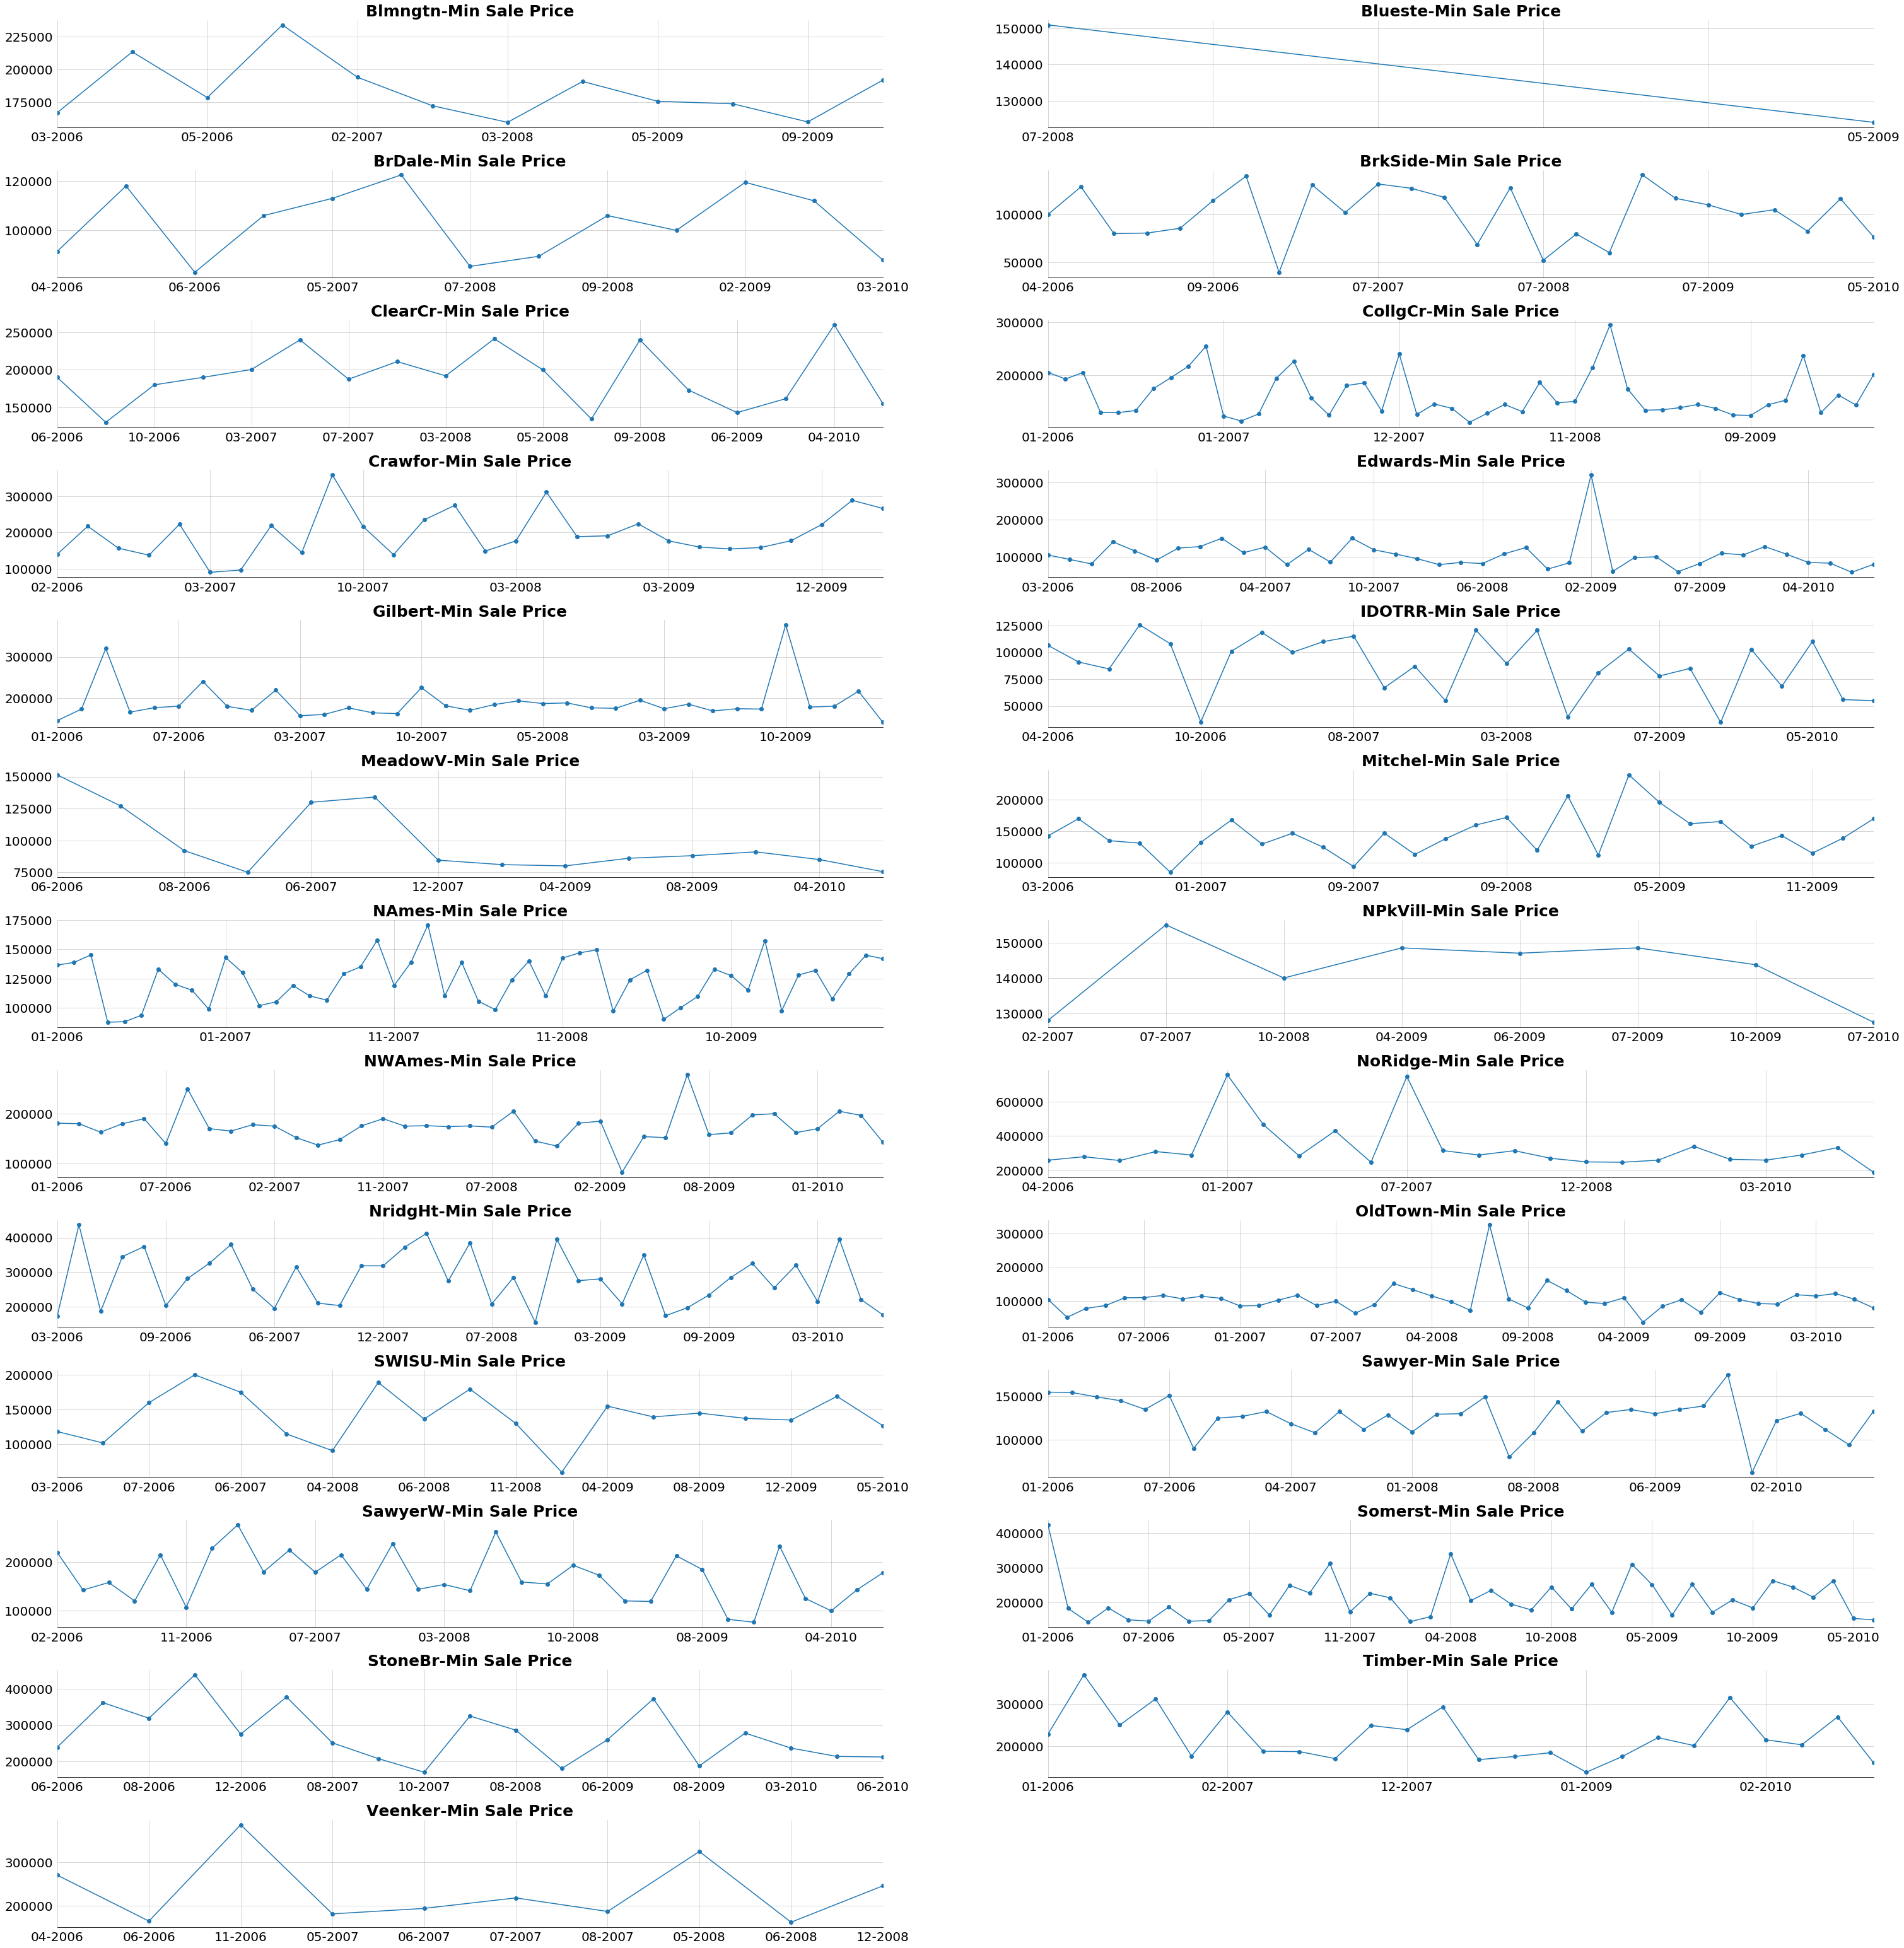

In [38]:
# Plot minimum sale price for each neighborhood
warnings.filterwarnings("ignore")
fig, axes = plt.subplots(figsize=(50,50), 
                        nrows=n_rows, ncols=2,     # fix as above
                        gridspec_kw=dict(hspace=0.4))
fig.subplots_adjust(bottom=0.08, top=0.92,left=0.1,wspace = 0.2,hspace = 0.4)
# fig.suptitle('Minimum Sale Price by Region')
axes_list = [item for sublist in axes for item in sublist] 
for region_name, selection in df1.groupby('Neighborhood'):
    ax = axes_list.pop(0)
    #print(selection)
    selection.plot(x='Date', y='SalePrice_min', style='o-',label=region_name, ax=ax, legend=False)
    ax.set_title(region_name +'-'+'Min Sale Price',fontsize=25,fontweight='bold')
    ax.tick_params(
        which='both',
        bottom='off',
        left='off',
        right='off',
        top='off'
    )
    
    ax.grid(linewidth=0.5)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=20)

# Now use the matplotlib .remove() method to 
# delete anything we didn't use
for ax in axes_list:
    ax.remove()

plt.tight_layout()
plt.subplots_adjust(hspace=1)
# plt.savefig('SalePrice_min.png')

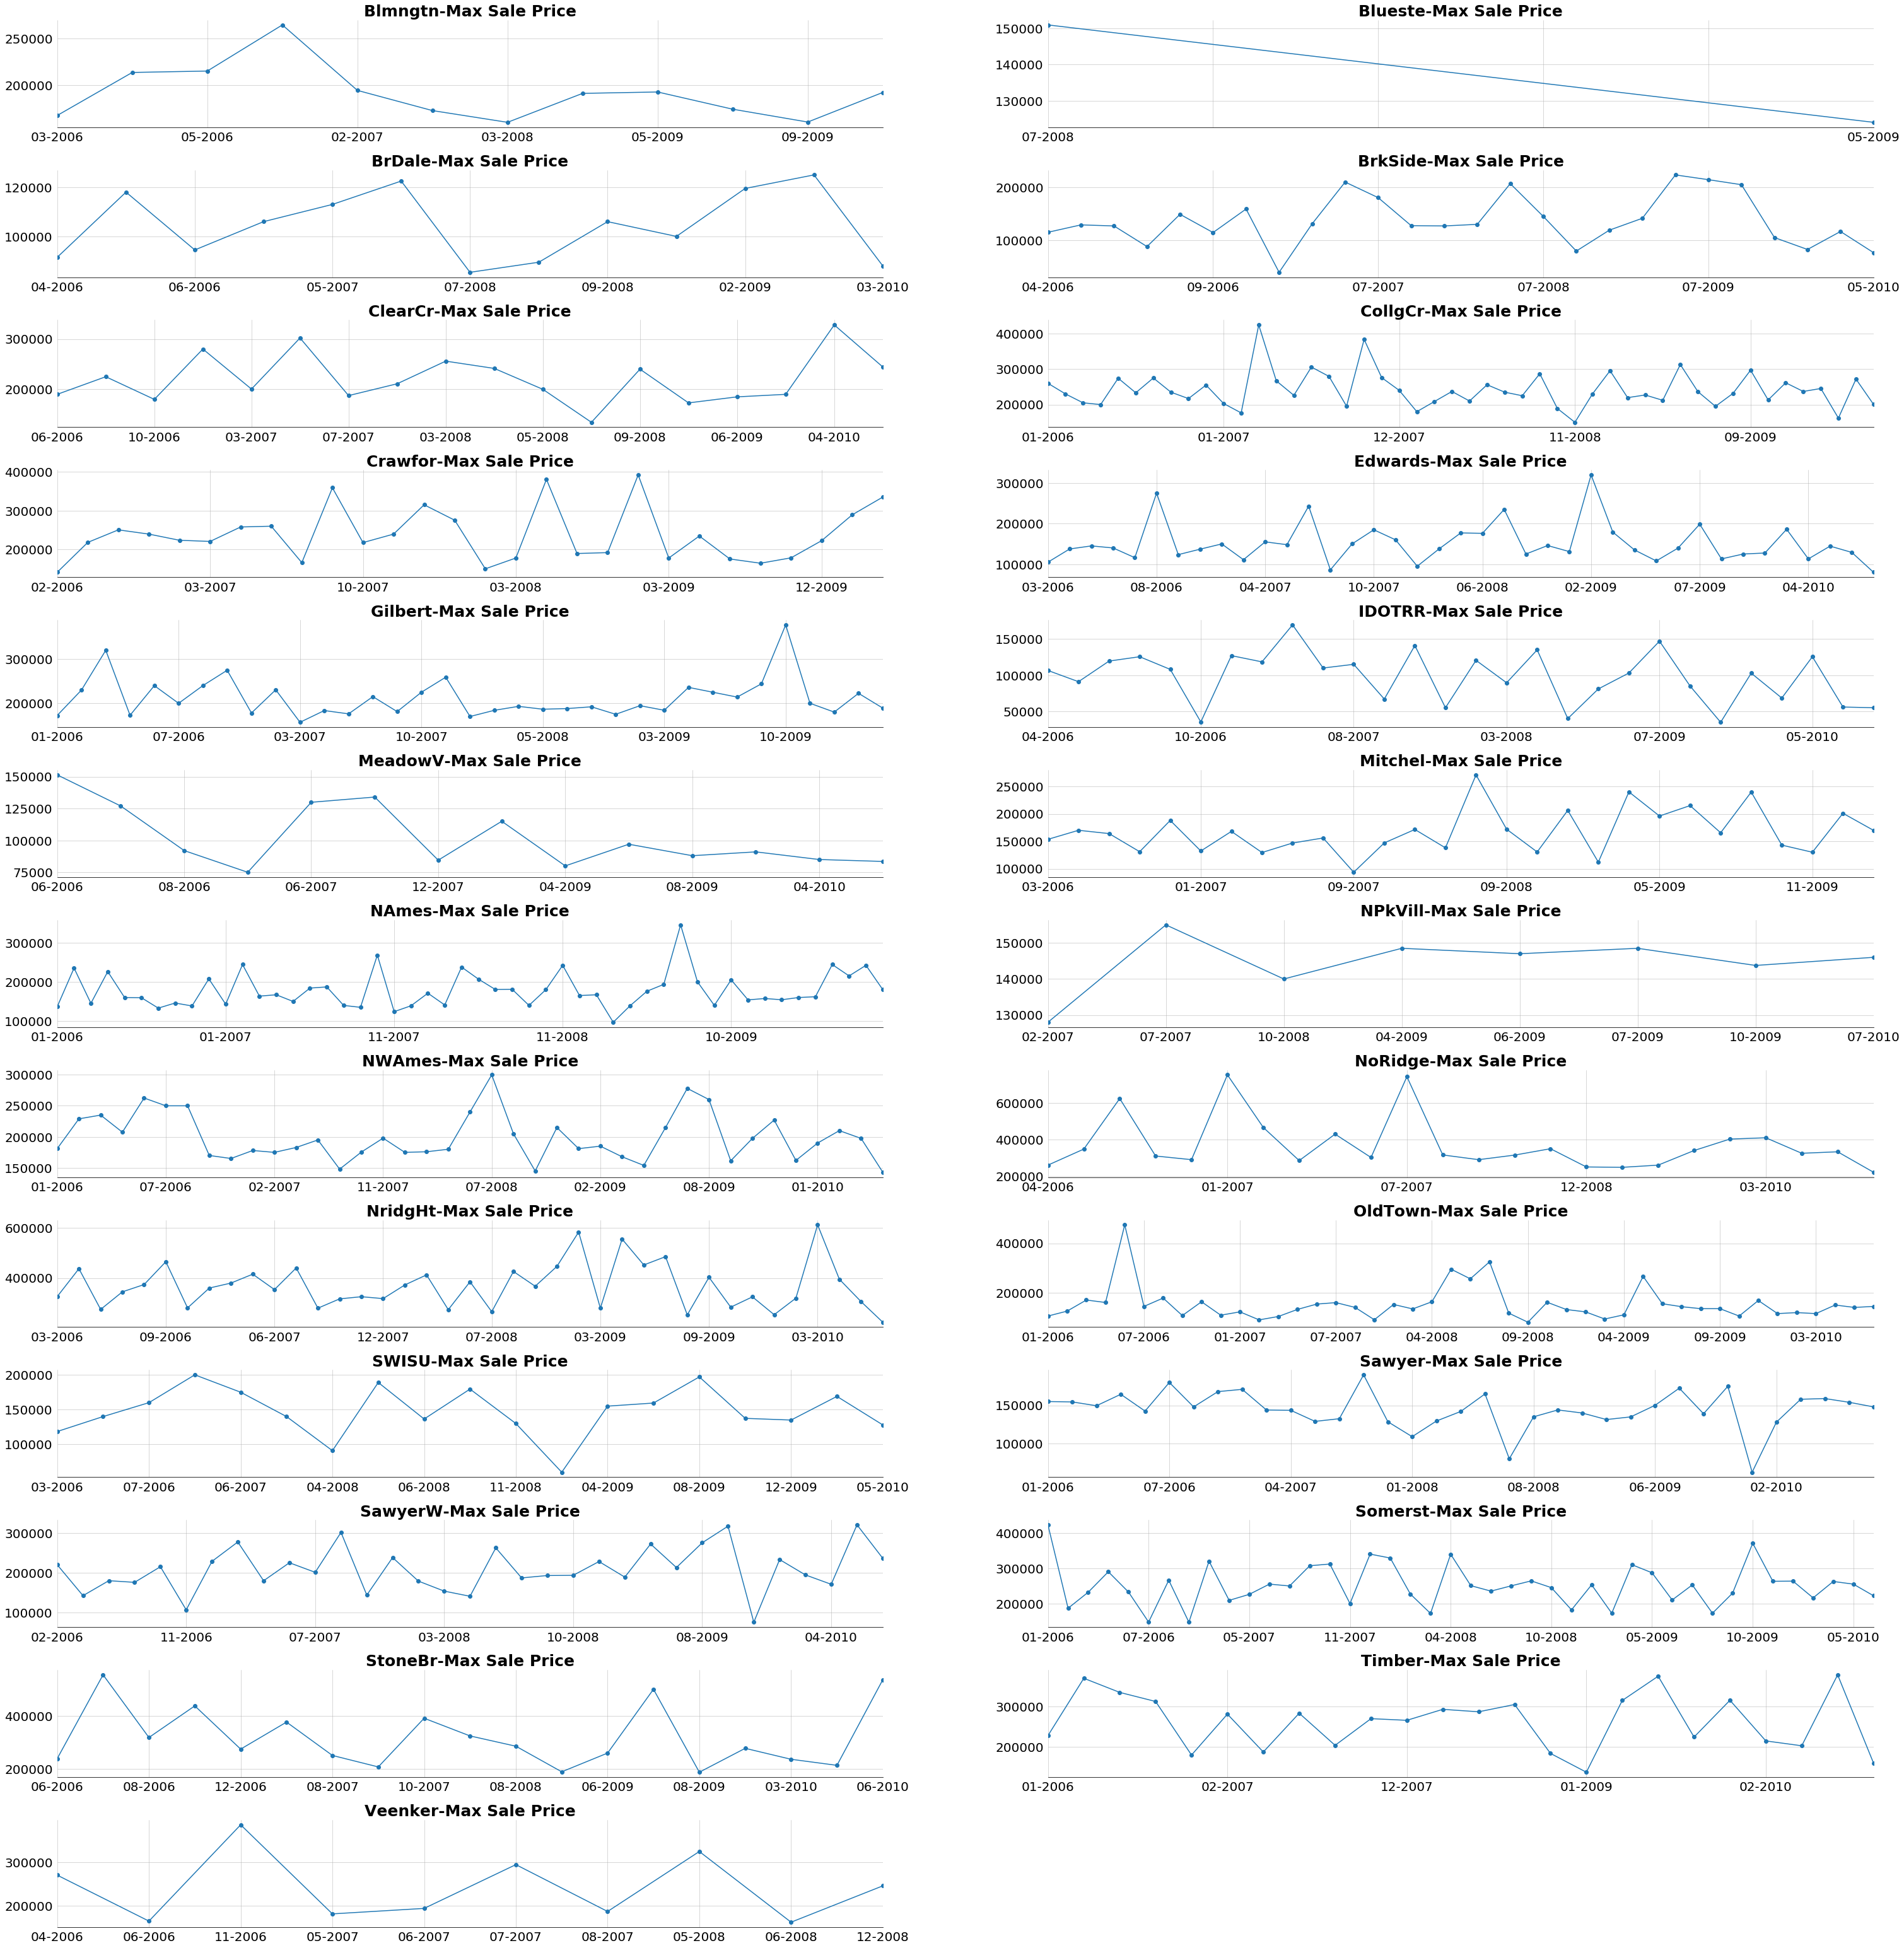

In [39]:
# Plot maximum sale price for each neighborhood
warnings.filterwarnings("ignore")
fig, axes = plt.subplots(figsize=(50,50), 
                        nrows=n_rows, ncols=2,     # fix as above
                        gridspec_kw=dict(hspace=0.4))
fig.subplots_adjust(bottom=0.08, top=0.92,left=0.1,wspace = 0.2,hspace = 0.4)
# fig.suptitle('Minimum Sale Price by Region')
axes_list = [item for sublist in axes for item in sublist] 
for region_name, selection in df1.groupby('Neighborhood'):
    ax = axes_list.pop(0)
    #print(selection)
    selection.plot(x='Date', y='SalePrice_max', style='o-',label=region_name, ax=ax, legend=False)
    ax.set_title(region_name +'-'+'Max Sale Price',fontsize=25,fontweight='bold')
    ax.tick_params(
        which='both',
        bottom='off',
        left='off',
        right='off',
        top='off'
    )
    
    ax.grid(linewidth=0.5)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=20)

# Now use the matplotlib .remove() method to 
# delete anything we didn't use
for ax in axes_list:
    ax.remove()

plt.tight_layout()
plt.subplots_adjust(hspace=1)
# plt.savefig('SalePrice_max.png')

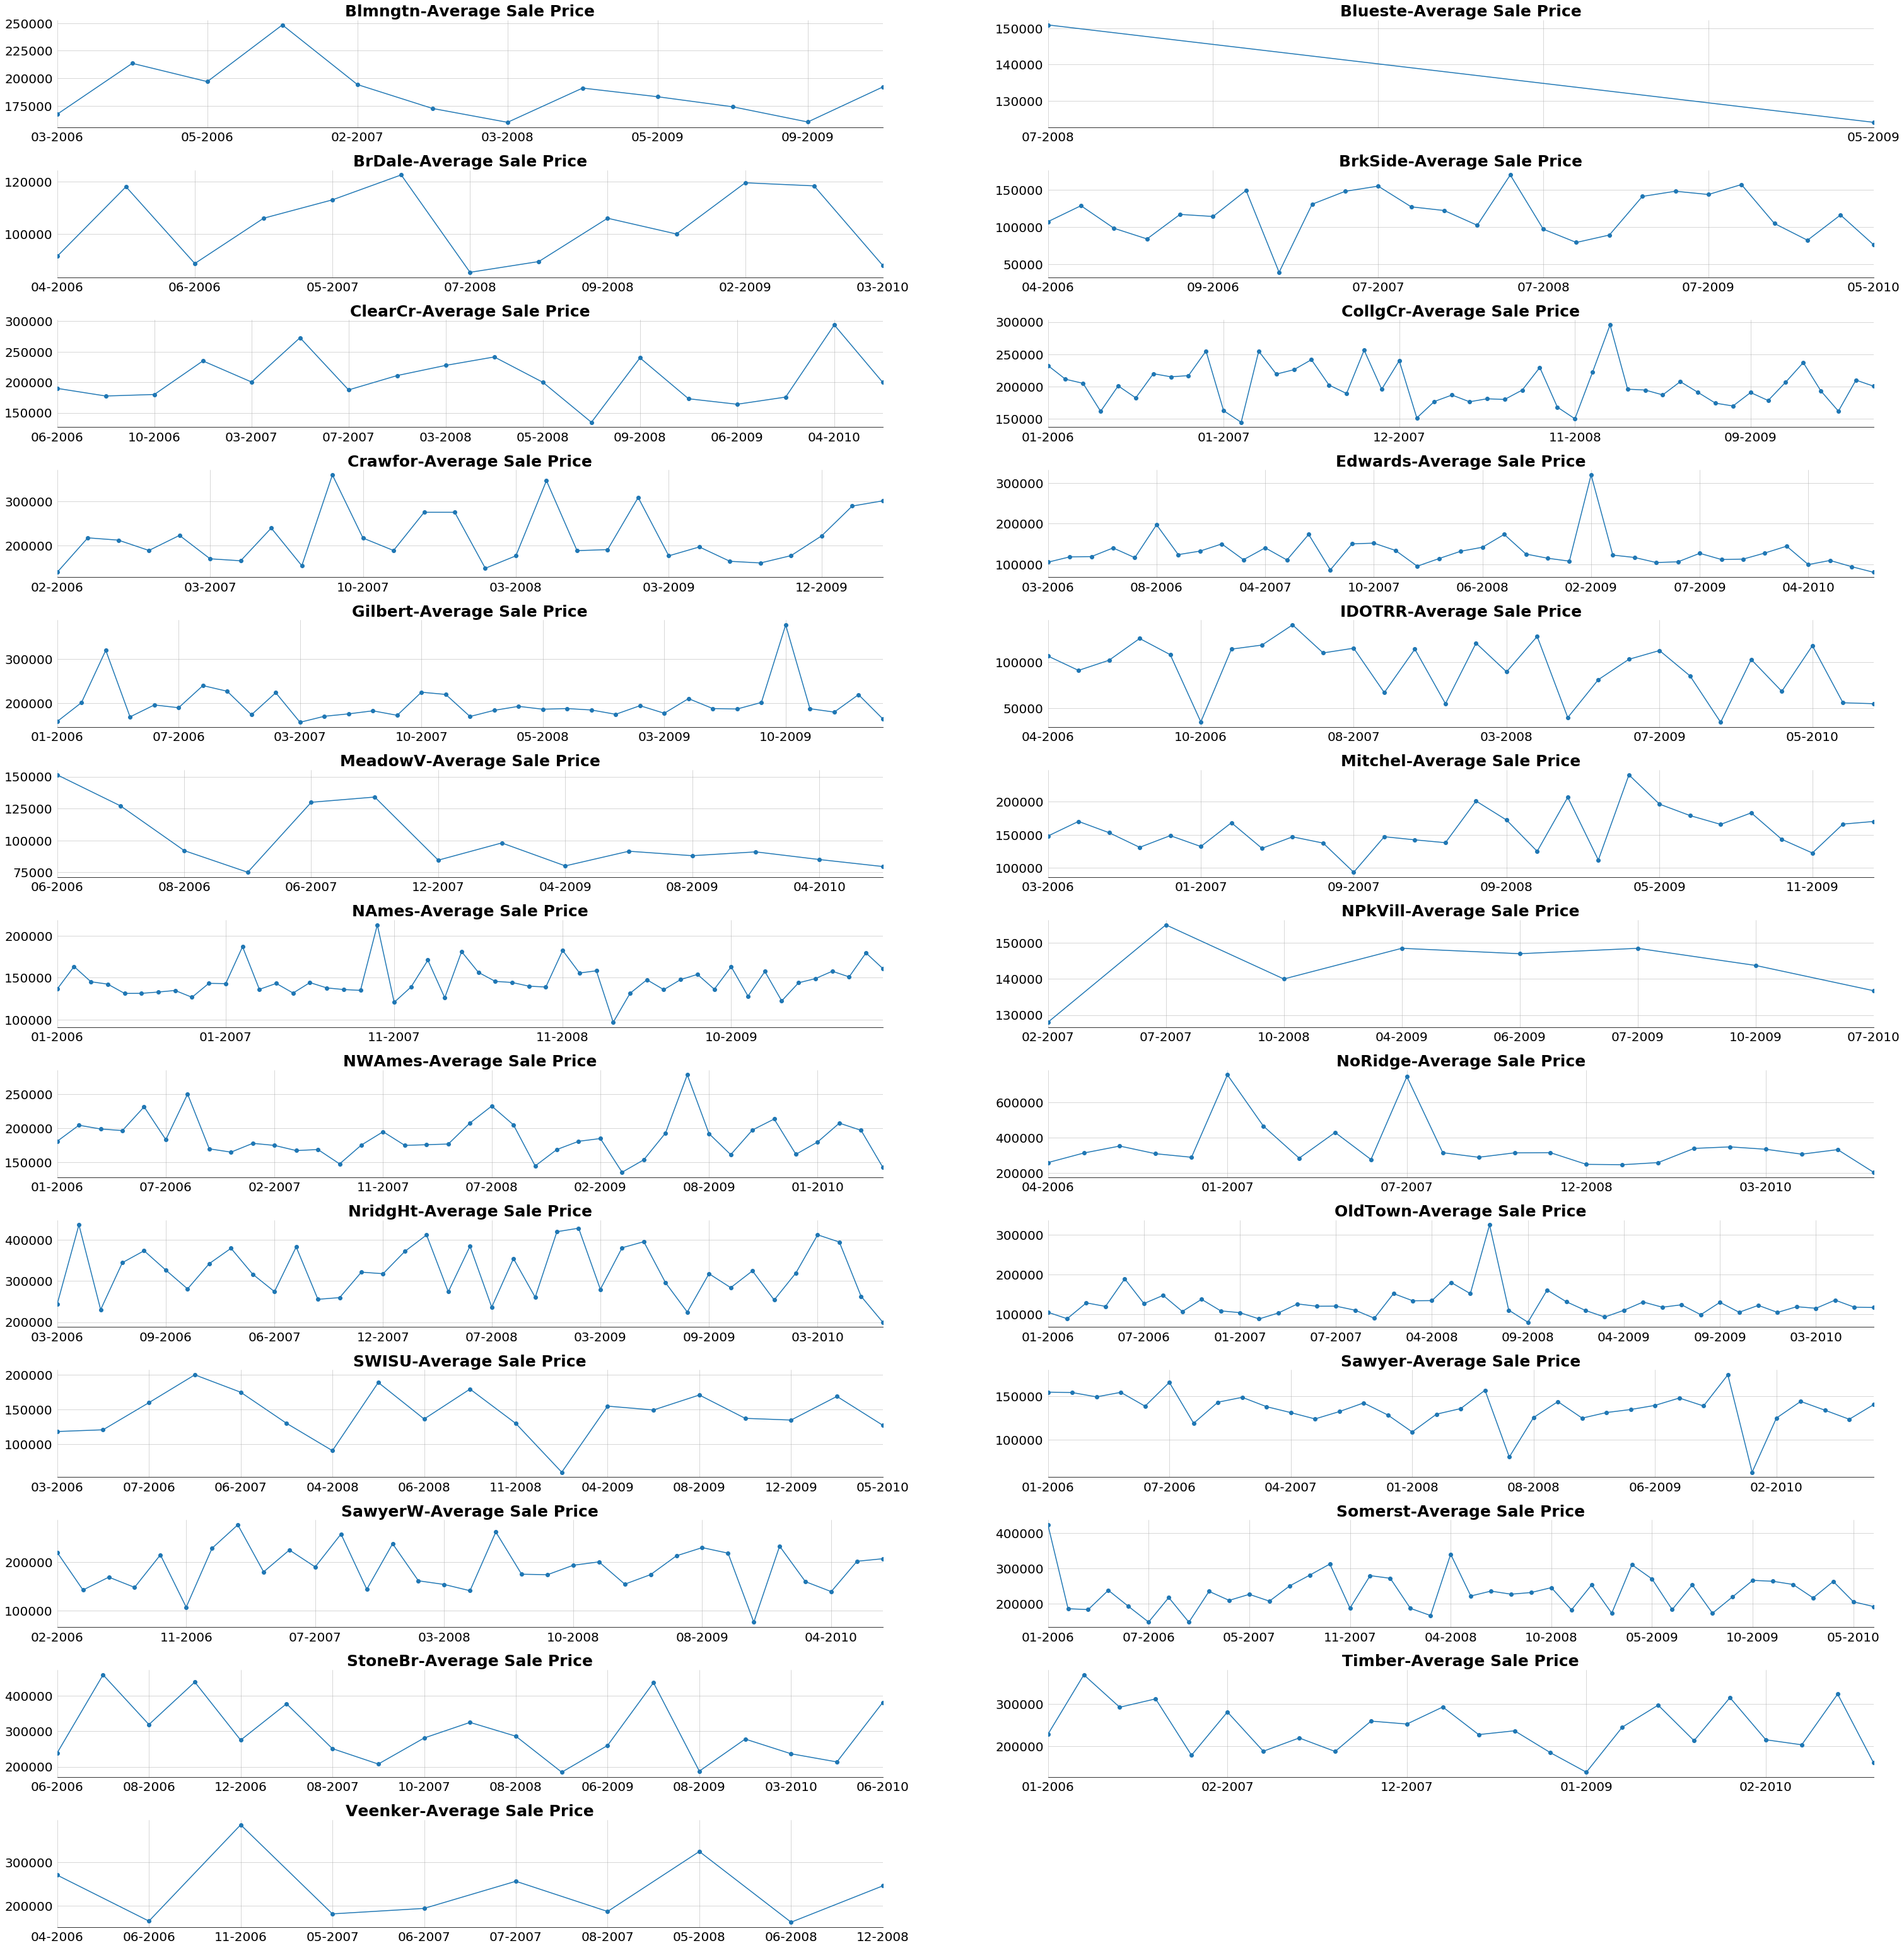

In [40]:
# Plot average sale price for each neighborhood
warnings.filterwarnings("ignore")
fig, axes = plt.subplots(figsize=(50,50), 
                        nrows=n_rows, ncols=2,     # fix as above
                        gridspec_kw=dict(hspace=0.4))
fig.subplots_adjust(bottom=0.08, top=0.92,left=0.1,wspace = 0.2,hspace = 0.4)
# fig.suptitle('Minimum Sale Price by Region')
axes_list = [item for sublist in axes for item in sublist] 
for region_name, selection in df1.groupby('Neighborhood'):
    ax = axes_list.pop(0)
    #print(selection)
    selection.plot(x='Date', y='SalePrice_mean', style='o-',label=region_name, ax=ax, legend=False)
    ax.set_title(region_name +'-'+'Average Sale Price',fontsize=25,fontweight='bold')
    ax.tick_params(
        which='both',
        bottom='off',
        left='off',
        right='off',
        top='off'
    )
    
    ax.grid(linewidth=0.5)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=20)

# Now use the matplotlib .remove() method to 
# delete anything we didn't use
for ax in axes_list:
    ax.remove()

plt.tight_layout()
plt.subplots_adjust(hspace=1)
# plt.savefig('SalePrice_mean.png')

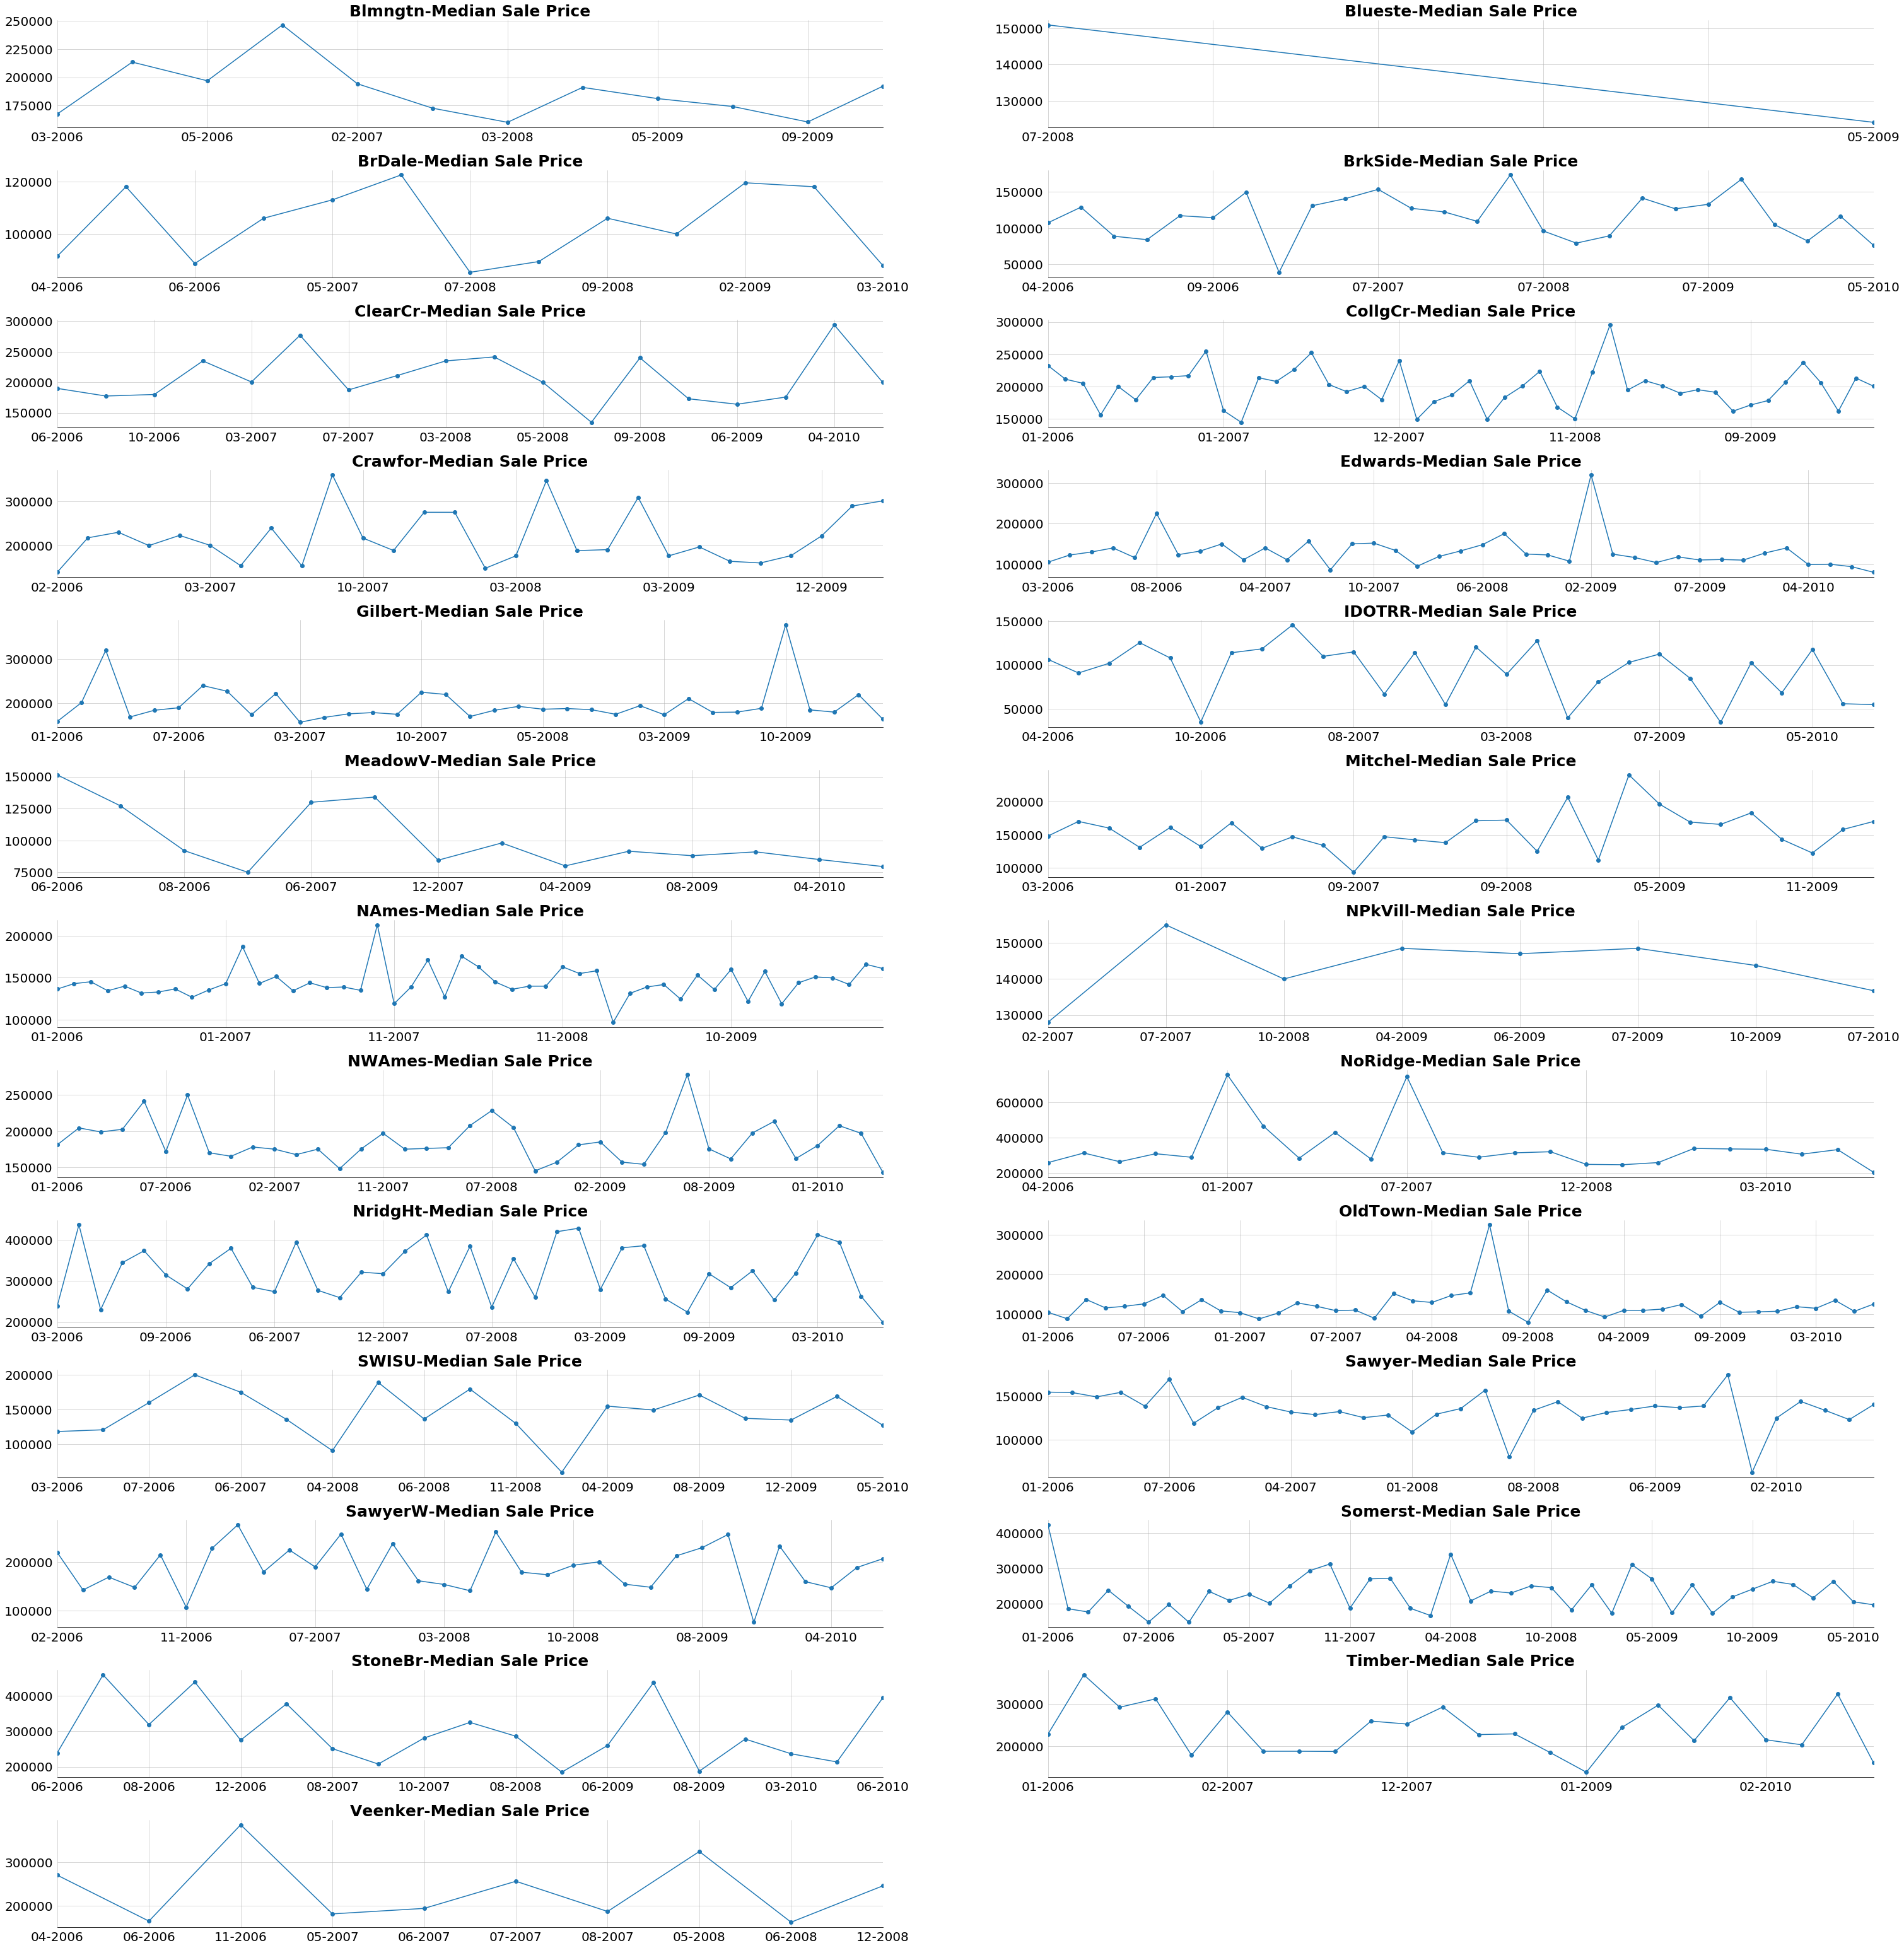

In [41]:
# Plot median sale price for each neighborhood
warnings.filterwarnings("ignore")
fig, axes = plt.subplots(figsize=(50,50), 
                        nrows=n_rows, ncols=2,     # fix as above
                        gridspec_kw=dict(hspace=0.4))
fig.subplots_adjust(bottom=0.08, top=0.92,left=0.1,wspace = 0.2,hspace = 0.4)
# fig.suptitle('Minimum Sale Price by Region')
axes_list = [item for sublist in axes for item in sublist] 
for region_name, selection in df1.groupby('Neighborhood'):
    ax = axes_list.pop(0)
    #print(selection)
    selection.plot(x='Date', y='SalePrice_median', style='o-',label=region_name, ax=ax, legend=False)
    ax.set_title(region_name +'-'+'Median Sale Price',fontsize=25,fontweight='bold')
    ax.tick_params(
        which='both',
        bottom='off',
        left='off',
        right='off',
        top='off'
    )
    
    ax.grid(linewidth=0.5)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=20)

# Now use the matplotlib .remove() method to 
# delete anything we didn't use
for ax in axes_list:
    ax.remove()

plt.tight_layout()
plt.subplots_adjust(hspace=1)
# plt.savefig('SalePrice_median.png')

       Date  SalePrice_median
0   03-2006          167240.0
1   04-2006          213490.0
2   05-2006          196870.0
3   10-2006          246578.0
4   02-2007          194201.0
5   06-2007          172500.0
6   03-2008          159895.0
7   05-2008          191000.0
8   05-2009          181000.0
9   06-2009          174000.0
10  09-2009          160200.0
11  04-2010          192000.0


Text(0.5, 0, 'Date Sold')

<Figure size 432x288 with 0 Axes>

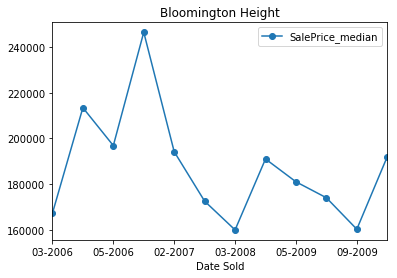

In [42]:
# Show the sub dataset for Neighborhood == 'Blmngtn'
df_Blmngtn = df1[df1['Neighborhood']=='Blmngtn'][['Date','SalePrice_median']]
df_Blmngtn.reset_index(drop=True, inplace=True)
print(df_Blmngtn)
plt.figure()
df_Blmngtn.plot(x='Date',y='SalePrice_median', style='o-',title='Bloomington Height')
plt.xlabel('Date Sold')

# plt.savefig('Blmngtn_SalePrice_median.png')

       Date  SalePrice_median
0   02-2006          220000.0
1   03-2006          142500.0
2   05-2006          169000.0
3   07-2006          147900.0
4   09-2006          215000.0
5   11-2006          107000.0
6   01-2007          228500.0
7   04-2007          277000.0
8   05-2007          179900.0
9   06-2007          225000.0
10  07-2007          190100.0
11  08-2007          258000.0
12  10-2007          144000.0
13  11-2007          238000.0
14  12-2007          161500.0
15  03-2008          153900.0
16  04-2008          141000.0
17  05-2008          262280.0
18  06-2008          179200.0
19  07-2008          174000.0
20  10-2008          193500.0
21  12-2008          200500.0
22  04-2009          154500.0
23  06-2009          148145.0
24  07-2009          213000.0
25  08-2009          229950.0
26  09-2009          257000.0
27  10-2009           76000.0
28  01-2010          233000.0
29  02-2010          159750.0
30  04-2010          147000.0
31  05-2010          189000.0
32  06-201

Text(0.5, 0, 'Date Sold')

<Figure size 432x288 with 0 Axes>

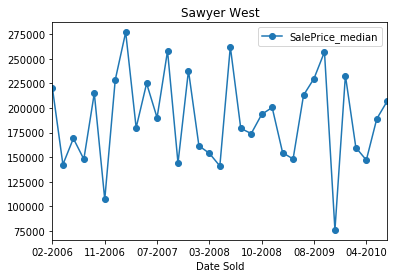

In [43]:
# Show the sub dataset for Neighborhood == 'SawyerW'
df_SawyerW = df1[df1['Neighborhood']=='SawyerW'][['Date','SalePrice_median']]
df_SawyerW.reset_index(drop=True, inplace=True)
print(df_SawyerW)
plt.figure()
df_SawyerW.plot(x='Date',y='SalePrice_median', style='o-',title='Sawyer West')
plt.xlabel('Date Sold')

# plt.savefig('SawyerW_SalePrice_median.png')

3) A client who wants to remodel their home and then sell it on the market, 
   and currently the house is 3 bedroom / 2 bathroom 1500 sq.ft. 
   There are three options for the remodel:
   (1) Adding a new bedroom measuring 130 sq.ft.
   (2) Adding a new half bathroom measuring 80 sq.ft. 
   (3) Expanding the living room by 400 sq.ft. 
   (the cost of all three remodel options is equal)

In [44]:
# Copy dataset for question 3
q3_df = dataset.copy()

In [45]:
# Add Porch square feet (PorchSF) and indoor square feet (IndoorSF) column
q3_df['PorchSF'] = q3_df['OpenPorchSF'] + q3_df['EnclosedPorch'] + q3_df['3SsnPorch'] + q3_df['ScreenPorch']
q3_df['IndoorSF'] = q3_df['GrLivArea'] + q3_df['TotalBsmtSF'] \
                         - q3_df['PorchSF'] \
                         - q3_df['GarageArea'] \
                         - q3_df['WoodDeckSF'] \
                         - q3_df['MasVnrArea']
print(q3_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 83 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [46]:
# For simplification here, only 7 columns are selected for modeling purpose
q3_df_model = q3_df[['SalePrice','Neighborhood','LotFrontage', 'IndoorSF','FullBath','HalfBath','BedroomAbvGr']].copy()
# Drop the observations containing NAs 
# (alternatively we can use imputation methods such as median to deal with missing values)
q3_df_model = q3_df_model.dropna()
q3_df_model['log_SalePrice'] = np.log(q3_df_model['SalePrice'])
print('1) The shape of the data for modeling: ', q3_df_model.shape)
print('2) A subset of the data for modeling: ', q3_df_model.head(), sep='\n')

1) The shape of the data for modeling:  (1195, 8)
2) A subset of the data for modeling: 
   SalePrice Neighborhood  LotFrontage  IndoorSF  FullBath  HalfBath  \
0     208500      CollgCr         65.0    1761.0         2         1   
1     181500      Veenker         80.0    1766.0         2         0   
2     223500      CollgCr         68.0    1894.0         2         1   
3     140000      Crawfor         60.0    1524.0         1         0   
4     250000      NoRidge         84.0    1881.0         2         1   

   BedroomAbvGr  log_SalePrice  
0             3      12.247694  
1             3      12.109011  
2             3      12.317167  
3             3      11.849398  
4             4      12.429216  


3.2) Statistical Modeling Analysis 

In [47]:
# Get the dataset for OLS (data_OLS): Merge original model data with dummied 'Neighborhood' variable
data_OLS = pd.concat((q3_df_model,pd.get_dummies(q3_df_model['Neighborhood'], drop_first=True)), axis=1)

In [48]:
# OLS regression
import statsmodels.api as sm
y = data_OLS['log_SalePrice']
X = data_OLS.drop(['SalePrice', 'Neighborhood', 'log_SalePrice'], axis=1)
X = sm.add_constant(X)
model = sm.OLS(y,X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          log_SalePrice   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     111.4
Date:                Wed, 30 Oct 2019   Prob (F-statistic):          1.90e-311
Time:                        22:08:48   Log-Likelihood:                 147.12
No. Observations:                1195   AIC:                            -234.2
Df Residuals:                    1165   BIC:                            -81.66
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           11.4792      0.065    176.139   

In [ ]:
# Save model summary to a csv file
with open('model_summary.csv', 'w') as MR:
    MR.write(model.summary().as_csv())

In [ ]:
# Althernatively, we can use sklearn to do
# Linear Regression, Decision Tree Regression, and Random Forest Regression below

from sklearn.model_selection import train_test_split
import seaborn as sns
# sns.set(style="white")
# sns.set(style="whitegrid", color_codes=True)

In [ ]:
# plot heatmap for correlation

corr = q3_df_model.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
# Get array from dataframe for X and y
X = q3_df_model.iloc[:,1:7].values
y = q3_df_model.iloc[:,-1].values

In [ ]:
q3_model_1 = q3_df_model.iloc[:,1:7].copy()

new = [('CollgCr', 80, 1630, 2,0,4),
       ('CollgCr', 80, 1580, 2,1,3),
       ('CollgCr', 80, 1900, 2,0,3)]
new_df = pd.DataFrame(new, columns = q3_model_1.columns)

q3_model_2 = q3_model_1.append(new_df, ignore_index=True)
# df32.tail()
x_new = q3_model_2.values
x_new[0]

In [ ]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
warnings.filterwarnings("ignore")

labelencoder_X = LabelEncoder()
x_new[:, 0] = labelencoder_X.fit_transform(x_new[:, 0])

onehotencoder = OneHotEncoder(categorical_features = [0])
x_new = onehotencoder.fit_transform(x_new).toarray()
x_new[-1]

In [ ]:
x_option1 = x_new[-3]
x_option2 = x_new[-2]
x_option3 = x_new[-1]

In [ ]:
x_new.shape
col = ['coef_x_%d'%i for i in range(1,32)]

In [ ]:
# Split data into training set and testing set
X_train, X_test, y_train, y_test = train_test_split(x_new[:1195,:],y, test_size=0.25, random_state=42)

In [ ]:
# Linear regression in sklearn
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
regressor_LR = LinearRegression()
regressor_LR.fit(X_train, y_train)
# Predicting the testing set results with Linear Regression
y_predict_LR = regressor_LR.predict(X_test)


In [ ]:
regressor_LASSO = Lasso(max_iter = 10000, normalize = True)
regressor_LASSO_cv = LassoCV(alphas = None, cv = 10, max_iter = 100000, normalize = True)
regressor_LASSO_cv.fit(X_train, y_train)

regressor_LASSO.set_params(alpha = regressor_LASSO_cv.alpha_)
regressor_LASSO.fit(X_train, y_train)
y_fitted_LASSO = regressor_LASSO.predict(X_train)
y_predict_LASSO = regressor_LASSO.predict(X_test)

In [ ]:
print('Intercept: \n', regressor_LASSO.intercept_) 
coef_df = pd.DataFrame(regressor_LASSO.coef_, index = col, columns = ['Coef'])
fitted_df = pd.DataFrame(y_fitted_LASSO, index = [i for i in range(len(X_train))], columns = ['FittedValue'])
coef_df[coef_df['Coef']==0]

In [ ]:
# Decision Tree Regression
from sklearn.tree import DecisionTreeRegressor
regressor_DTR = DecisionTreeRegressor(random_state = 0)
regressor_DTR.fit(X_train, y_train)
# Predicting the testing set results with Decision Tree Regression
y_predict_DTR = regressor_DTR.predict(X_test)

# Random Forest Regression
from sklearn.ensemble import RandomForestRegressor
regressor_RFR = RandomForestRegressor(n_estimators = 300, random_state = 0)
regressor_RFR.fit(X_train, y_train)

# Predicting testing set results with Random Forest Regression 
y_predict_RFR = regressor_RFR.predict(X_test)

In [ ]:
x_option1_1 = x_option1.reshape(1, -1)
y_pred_option1 = regressor_RFR.predict(x_option1_1)
y_pred_option1

In [ ]:
x_option2_1 = x_option2.reshape(1, -1)
y_pred_option2 = regressor_RFR.predict(x_option2_1)
y_pred_option2

In [ ]:
x_option3_1 = x_option3.reshape(1, -1)
y_pred_option3 = regressor_RFR.predict(x_option3_1)
y_pred_option3

In [ ]:
print('Predicted Sale Price for Option 1: ', math.exp(y_pred_option1[0]))
print('Predicted Sale Price for Option 2: ', math.exp(y_pred_option2[0]))
print('Predicted Sale Price for Option 3: ', math.exp(y_pred_option3[0]))

In [ ]:
# Metric (Root Mean Squared Error) to compare different model performance
from sklearn.metrics import mean_squared_error
mse_LR = mean_squared_error(y_test,y_predict_LR)
rmse_LR = np.sqrt(mse_LR)
print('Root Mean Squared Error for Linear Regression',rmse_LR)

mse_DTR = mean_squared_error(y_test,y_predict_DTR)
rmse_DTR = np.sqrt(mse_DTR)
print('Root Mean Squared Error for Decision Tree Regression',rmse_DTR)

mse_RFR = mean_squared_error(y_test,y_predict_RFR)
rmse_RFR = np.sqrt(mse_RFR)
print('Root Mean Squared Error for Random Forest Regression',rmse_RFR)

3.1) Analysis from the Dataset Itself 

In [49]:
# Combine YearSold and MonthSold to create DateSold column  
q3_df = q3_df.groupby(["Neighborhood"]).apply(lambda x: x.sort_values(['YrSold','MoSold'])).reset_index(drop=True)
q3_df['Date'] = q3_df['MoSold'].map(str)+ '-' + q3_df['YrSold'].map(str)
q3_df['Date'] = pd.to_datetime(q3_df['Date'], format='%m-%Y').dt.strftime('%m-%Y')

In [50]:
# Option1: Adding a new bedroom measuring 130 sq.ft.
df_opt1 = q3_df[(q3_df['IndoorSF'] >= 1630) & (q3_df['BedroomAbvGr'] == 4) & (q3_df['FullBath'] == 2)] \
[['YrSold','MoSold','Date','SalePrice','IndoorSF','Neighborhood','BsmtHalfBath','HalfBath','FullBath','BedroomAbvGr']].copy()
print(df_opt1.head())

     YrSold  MoSold     Date  SalePrice  IndoorSF Neighborhood  BsmtHalfBath  \
66     2008       6  06-2008     184000    2506.0      BrkSide             0   
93     2006       6  06-2006     190000    1829.0      ClearCr             1   
100    2007       6  06-2007     277000    2629.0      ClearCr             1   
104    2007       9  09-2007     211000    2002.0      ClearCr             1   
106    2008       3  03-2008     192000    1973.0      ClearCr             0   

     HalfBath  FullBath  BedroomAbvGr  
66          0         2             4  
93          0         2             4  
100         0         2             4  
104         1         2             4  
106         1         2             4  


In [51]:
# Get aggregated dataset to check the statistics of sale price for option1
agg_opt1 = df_opt1.agg({"SalePrice": [min, max, 'mean','median']})
agg_opt1 = agg_opt1.rename(columns={'SalePrice':'SalePrice_opt1'})

In [52]:
# Group the option1 dataset by Month Sold
agg_mo_opt1 = df_opt1.groupby(['MoSold']).agg({"SalePrice": [min, max, 'mean','median']})
agg_mo_opt1.columns = ["_".join(x) for x in agg_mo_opt1.columns.ravel()]
agg_mo_opt1.rename(columns={'SalePrice_min':'SalePriceMin_opt1','SalePrice_max':'SalePriceMax_opt1','SalePrice_mean':'SalePriceAvg_opt1','SalePrice_median':'SalePriceMedian_opt1'}, inplace=True)
agg_mo_opt1 = agg_mo_opt1.reset_index()
print(agg_mo_opt1.head())

   MoSold  SalePriceMin_opt1  SalePriceMax_opt1  SalePriceAvg_opt1  \
0       1             214000             233000      223500.000000   
1       2             214900             281213      238778.250000   
2       3             162900             410000      237985.714286   
3       4             122500             437154      226070.266667   
4       5              87000             333168      227070.666667   

   SalePriceMedian_opt1  
0                223500  
1                229500  
2                192000  
3                236000  
4                259090  


In [53]:
# Group the option1 dataset by Date Sold
grouped_NoRegion_opt1 = df_opt1.groupby(['Date','YrSold','MoSold']).agg({"SalePrice": [min, max, 'mean','median']})
grouped_NoRegion_opt1.columns = ["_".join(x) for x in grouped_NoRegion_opt1.columns.ravel()]

agg_NoRegion_opt1 = grouped_NoRegion_opt1.reset_index().sort_values(['YrSold','MoSold'])
agg_NoRegion_opt1.rename(columns={'SalePrice_min':'SalePriceMin_opt1','SalePrice_max':'SalePriceMax_opt1','SalePrice_mean':'SalePriceAvg_opt1','SalePrice_median':'SalePriceMedian_opt1'}, inplace=True)

print(agg_NoRegion_opt1.head())

       Date  YrSold  MoSold  SalePriceMin_opt1  SalePriceMax_opt1  \
2   02-2006    2006       2             229000             230000   
5   03-2006    2006       3             162900             320000   
8   04-2006    2006       4             137000             437154   
13  05-2006    2006       5              87000             226000   
17  06-2006    2006       6             102000             475000   

    SalePriceAvg_opt1  SalePriceMedian_opt1  
2            229500.0                229500  
5            239300.0                235000  
8            283830.8                260000  
13           156500.0                156500  
17           220400.0                190000  


In [54]:
# Group the option1 dataset by Neighborhood
grouped_NoDate_opt1 = df_opt1.groupby(['Neighborhood']).agg({"SalePrice": [min, max, 'mean','median']})
grouped_NoDate_opt1.columns = ["_".join(x) for x in grouped_NoDate_opt1.columns.ravel()]

agg_NoDate_opt1 = grouped_NoDate_opt1.reset_index().sort_values(['Neighborhood'])
agg_NoDate_opt1.rename(columns={'SalePrice_min':'SalePriceMin_opt1','SalePrice_max':'SalePriceMax_opt1','SalePrice_mean':'SalePriceAvg_opt1','SalePrice_median':'SalePriceMedian_opt1'}, inplace=True)

print(agg_NoDate_opt1.head())

  Neighborhood  SalePriceMin_opt1  SalePriceMax_opt1  SalePriceAvg_opt1  \
0      BrkSide             184000             184000      184000.000000   
1      ClearCr             190000             277000      222880.000000   
2      CollgCr             195000             383970      255228.333333   
3      Crawfor             145000             359100      216825.000000   
4      Edwards             100000             274970      164897.500000   

   SalePriceMedian_opt1  
0              184000.0  
1              211000.0  
2              237700.0  
3              208000.0  
4              141400.0  


In [55]:
# Option2: Adding a new half bathroom measuring 80 sq.ft.
df_opt2 = q3_df[(q3_df['IndoorSF'] >= 1580) & (q3_df['BedroomAbvGr'] == 3) & (q3_df['FullBath'] == 2)& (q3_df['HalfBath'] == 1)] \
[['YrSold','MoSold','Date','SalePrice','IndoorSF','Neighborhood','BsmtHalfBath','HalfBath','FullBath','BedroomAbvGr']].copy()
print(df_opt2.head())

     YrSold  MoSold     Date  SalePrice  IndoorSF Neighborhood  BsmtHalfBath  \
17     2008       7  07-2008     151000    1659.0      Blueste             0   
86     2009      10  10-2009     205000    1610.0      BrkSide             0   
101    2007       6  06-2007     240000    2585.0      ClearCr             0   
114    2009       6  06-2009     185000    1890.0      ClearCr             1   
117    2010       4  04-2010     328000    2693.0      ClearCr             0   

     HalfBath  FullBath  BedroomAbvGr  
17          1         2             3  
86          1         2             3  
101         1         2             3  
114         1         2             3  
117         1         2             3  


In [56]:
# Get aggregated dataset to check the statistics of sale price for option2
agg_opt2 = df_opt2.agg({"SalePrice": [min, max, 'mean','median']})
agg_opt2 = agg_opt2.rename(columns={'SalePrice':'SalePrice_opt2'})

In [57]:
# Group the option2 dataset by Month Sold
agg_mo_opt2 = df_opt2.groupby(['MoSold']).agg({"SalePrice": [min, max, 'mean','median']})
agg_mo_opt2.columns = ["_".join(x) for x in agg_mo_opt2.columns.ravel()]
agg_mo_opt2.rename(columns={'SalePrice_min':'SalePriceMin_opt2','SalePrice_max':'SalePriceMax_opt2','SalePrice_mean':'SalePriceAvg_opt2','SalePrice_median':'SalePriceMedian_opt2'}, inplace=True)
agg_mo_opt2 = agg_mo_opt2.reset_index()
print(agg_mo_opt2)

    MoSold  SalePriceMin_opt2  SalePriceMax_opt2  SalePriceAvg_opt2  \
0        1             160000             248000      210316.666667   
1        2             173000             253000      206525.000000   
2        3             174000             412500      245190.000000   
3        4             148500             395192      255388.714286   
4        5             155000             415298      227061.650000   
5        6             174000             451950      220972.258065   
6        7             146000             372500      209433.531250   
7        8             129000             426000      223207.888889   
8        9             179665             402861      243581.375000   
9       10             137450             225000      190564.285714   
10      11             181000             446261      243651.000000   
11      12             173000             315000      231554.375000   

    SalePriceMedian_opt2  
0                 222250  
1                 2015

In [58]:
# Group the option2 dataset by Date Sold
grouped_NoRegion_opt2 = df_opt2.groupby(['Date','YrSold','MoSold']).agg({"SalePrice": [min, max, 'mean','median']})
grouped_NoRegion_opt2.columns = ["_".join(x) for x in grouped_NoRegion_opt2.columns.ravel()]

agg_NoRegion_opt2 = grouped_NoRegion_opt2.reset_index().sort_values(['YrSold','MoSold'])
agg_NoRegion_opt2.rename(columns={'SalePrice_min':'SalePriceMin_opt2','SalePrice_max':'SalePriceMax_opt2','SalePrice_mean':'SalePriceAvg_opt2','SalePrice_median':'SalePriceMedian_opt2'}, inplace=True)

print(agg_NoRegion_opt2.head())

       Date  YrSold  MoSold  SalePriceMin_opt2  SalePriceMax_opt2  \
0   01-2006    2006       1             172400             172400   
5   02-2006    2006       2             173000             220000   
9   03-2006    2006       3             186500             275500   
18  05-2006    2006       5             172785             172785   
23  06-2006    2006       6             176500             348000   

    SalePriceAvg_opt2  SalePriceMedian_opt2  
0       172400.000000              172400.0  
5       195166.666667              192500.0  
9       232333.333333              235000.0  
18      172785.000000              172785.0  
23      235237.500000              219950.0  


In [59]:
# Group the option2 dataset by Neighborhood
grouped_NoDate_opt2 = df_opt2.groupby(['Neighborhood']).agg({"SalePrice": [min, max, 'mean','median']})
grouped_NoDate_opt2.columns = ["_".join(x) for x in grouped_NoDate_opt2.columns.ravel()]

agg_NoDate_opt2 = grouped_NoDate_opt2.reset_index().sort_values(['Neighborhood'])
agg_NoDate_opt2.rename(columns={'SalePrice_min':'SalePriceMin_opt2','SalePrice_max':'SalePriceMax_opt2','SalePrice_mean':'SalePriceAvg_opt2','SalePrice_median':'SalePriceMedian_opt2'}, inplace=True)

print(agg_NoDate_opt2.head())

  Neighborhood  SalePriceMin_opt2  SalePriceMax_opt2  SalePriceAvg_opt2  \
0      Blueste             151000             151000      151000.000000   
1      BrkSide             205000             205000      205000.000000   
2      ClearCr             185000             328000      251000.000000   
3      CollgCr             155835             313000      217341.560976   
4      Crawfor             259500             315000      287250.000000   

   SalePriceMedian_opt2  
0                151000  
1                205000  
2                240000  
3                212000  
4                287250  


In [60]:
# Option3: Expanding the living room by 400 sq.ft.
df_opt3 = q3_df[(q3_df['IndoorSF'] >= 1900) & (q3_df['BedroomAbvGr'] == 3) & (q3_df['FullBath'] == 2)] \
[['YrSold','MoSold','Date','SalePrice','IndoorSF','Neighborhood','BsmtHalfBath','HalfBath','FullBath','BedroomAbvGr']].copy()
print(df_opt3.head())

     YrSold  MoSold     Date  SalePrice  IndoorSF Neighborhood  BsmtHalfBath  \
49     2006      10  10-2006     159000    2188.0      BrkSide             0   
65     2008       6  06-2008     162900    2291.0      BrkSide             0   
94     2006       7  07-2006     225000    2789.0      ClearCr             0   
101    2007       6  06-2007     240000    2585.0      ClearCr             0   
117    2010       4  04-2010     328000    2693.0      ClearCr             0   

     HalfBath  FullBath  BedroomAbvGr  
49          0         2             3  
65          0         2             3  
94          0         2             3  
101         1         2             3  
117         1         2             3  


In [61]:
# Get aggregated dataset to check the statistics of sale price for option3
agg_opt3 = df_opt3.agg({"SalePrice": [min, max, 'mean','median']})
agg_opt3 = agg_opt3.rename(columns={'SalePrice':'SalePrice_opt3'})

In [62]:
# Group the option3 dataset by Month Sold
agg_mo_opt3 = df_opt3.groupby(['MoSold']).agg({"SalePrice": [min, max, 'mean','median']})
agg_mo_opt3.columns = ["_".join(x) for x in agg_mo_opt3.columns.ravel()]

agg_mo_opt3.rename(columns={'SalePrice_min':'SalePriceMin_opt3','SalePrice_max':'SalePriceMax_opt3','SalePrice_mean':'SalePriceAvg_opt3','SalePrice_median':'SalePriceMedian_opt3'}, inplace=True)
agg_mo_opt3 = agg_mo_opt3.reset_index()
print(agg_mo_opt3.head())

   MoSold  SalePriceMin_opt3  SalePriceMax_opt3  SalePriceAvg_opt3  \
0       1             143000             295493      202557.750000   
1       2             173000             253000      218205.000000   
2       3             163500             412500      257666.571429   
3       4             130000             395192      229181.857143   
4       5             127000             415298      231082.757576   

   SalePriceMedian_opt3  
0              180450.0  
1              223350.0  
2              231000.0  
3              213500.0  
4              220000.0  


In [63]:
# Group the option3 dataset by Date Sold
grouped_NoRegion_opt3 = df_opt3.groupby(['Date','YrSold','MoSold']).agg({"SalePrice": [min, max, 'mean','median']})
grouped_NoRegion_opt3.columns = ["_".join(x) for x in grouped_NoRegion_opt3.columns.ravel()]

agg_NoRegion_opt3 = grouped_NoRegion_opt3.reset_index().sort_values(['YrSold','MoSold'])
agg_NoRegion_opt3.rename(columns={'SalePrice_min':'SalePriceMin_opt3','SalePrice_max':'SalePriceMax_opt3','SalePrice_mean':'SalePriceAvg_opt3','SalePrice_median':'SalePriceMedian_opt3'}, inplace=True)

print(agg_NoRegion_opt3.head())

       Date  YrSold  MoSold  SalePriceMin_opt3  SalePriceMax_opt3  \
0   01-2006    2006       1             155000             260000   
5   02-2006    2006       2             173000             230000   
10  03-2006    2006       3             217500             326000   
15  04-2006    2006       4             130000             232000   
20  05-2006    2006       5             130000             290000   

    SalePriceAvg_opt3  SalePriceMedian_opt3  
0       195800.000000              172400.0  
5       207666.666667              220000.0  
10      259500.000000              235000.0  
15      157375.000000              133750.0  
20      195714.285714              200000.0  


In [64]:
# Group the option3 dataset by Neighborhood
grouped_NoDate_opt3 = df_opt3.groupby(['Neighborhood']).agg({"SalePrice": [min, max, 'mean','median']})
grouped_NoDate_opt3.columns = ["_".join(x) for x in grouped_NoDate_opt3.columns.ravel()]

agg_NoDate_opt3 = grouped_NoDate_opt3.reset_index().sort_values(['Neighborhood'])
agg_NoDate_opt3.rename(columns={'SalePrice_min':'SalePriceMin_opt3','SalePrice_max':'SalePriceMax_opt3','SalePrice_mean':'SalePriceAvg_opt3','SalePrice_median':'SalePriceMedian_opt3'}, inplace=True)

print(agg_NoDate_opt3.head())

  Neighborhood  SalePriceMin_opt3  SalePriceMax_opt3  SalePriceAvg_opt3  \
0      BrkSide             159000             162900      160950.000000   
1      ClearCr             225000             328000      264333.333333   
2      CollgCr             124000             313000      224056.642857   
3      Crawfor             191000             335000      251937.500000   
4      Edwards             130000             160000      137500.000000   

   SalePriceMedian_opt3  
0                160950  
1                240000  
2                220500  
3                240250  
4                130000  


In [65]:
# Merge all general statistics summary for different options
agg_dfs = [agg_opt1,agg_opt2,agg_opt3]
merge_result = reduce(lambda left,right: pd.merge(left, right, 
                                              left_index=True, right_index=True, 
                                              how='inner'), agg_dfs)
# merge_result.to_excel('agg_option.xlsx')

In [66]:
# Merge dataset grouped by month sold for different options
agg_mo_dfs = [agg_mo_opt1,agg_mo_opt2,agg_mo_opt3]
merge_mo_result = reduce(lambda left,right: pd.merge(left, right, 
                                              on=['MoSold'], 
                                              how='inner'), agg_mo_dfs)
# merge_mo_result.to_excel('agg_mo_option.xlsx')


In [67]:
# Merge dataset grouped by neighborhood for different options
agg_re_dfs = [agg_NoDate_opt1,agg_NoDate_opt2,agg_NoDate_opt3]
merge_re_result = reduce(lambda left,right: pd.merge(left, right, 
                                              on=['Neighborhood'], 
                                              how='inner'), agg_re_dfs)
# merge_re_result.to_excel('agg_re_option.xlsx')


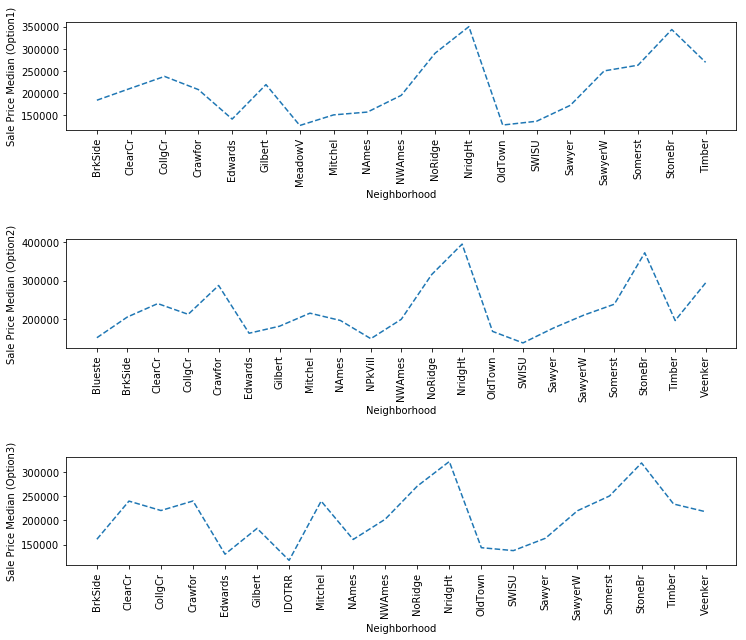

In [68]:
# Plot median sale price by neighborhood for different options
fig,(ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1,figsize=(12, 10),gridspec_kw=dict(hspace=1.0))
ax1.plot(np.arange(len(agg_NoDate_opt1['Neighborhood'])), agg_NoDate_opt1['SalePriceMedian_opt1'],'--')
ax1.xaxis.set_ticks(np.arange(len(agg_NoDate_opt1['Neighborhood'])))
ax1.xaxis.set_ticklabels(agg_NoDate_opt1['Neighborhood'], rotation=90)
ax1.set_xlabel("Neighborhood")
ax1.set_ylabel("Sale Price Median (Option1)")

ax2.plot(np.arange(len(agg_NoDate_opt2['Neighborhood'])), agg_NoDate_opt2['SalePriceMedian_opt2'],'--')
ax2.xaxis.set_ticks(np.arange(len(agg_NoDate_opt2['Neighborhood'])))
ax2.xaxis.set_ticklabels(agg_NoDate_opt2['Neighborhood'], rotation=90)
ax2.set_xlabel("Neighborhood")
ax2.set_ylabel("Sale Price Median (Option2)")

ax3.plot(np.arange(len(agg_NoDate_opt3['Neighborhood'])), agg_NoDate_opt3['SalePriceMedian_opt3'],'--')
ax3.xaxis.set_ticks(np.arange(len(agg_NoDate_opt3['Neighborhood'])))
ax3.xaxis.set_ticklabels(agg_NoDate_opt3['Neighborhood'], rotation=90)
ax3.set_xlabel("Neighborhood")
ax3.set_ylabel("Sale Price Median (Option3)")
fig.savefig('SalePrice_median_by_region.png')

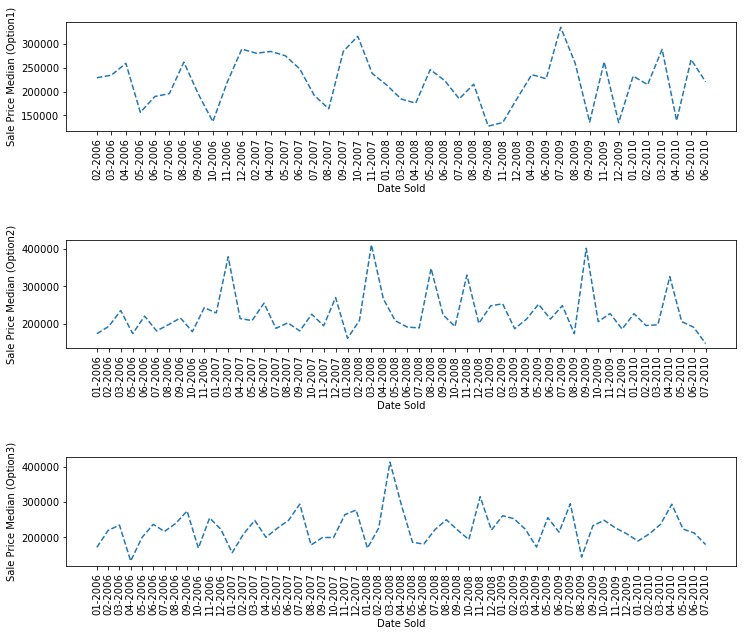

In [69]:
# Plot median sale price by date sold for different options
fig,(ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1,figsize=(12, 10),gridspec_kw=dict(hspace=1.0))
ax1.plot(np.arange(len(agg_NoRegion_opt1['Date'])), agg_NoRegion_opt1['SalePriceMedian_opt1'],'--')
ax1.xaxis.set_ticks(np.arange(len(agg_NoRegion_opt1['Date'])))
ax1.xaxis.set_ticklabels(agg_NoRegion_opt1['Date'], rotation=90)
ax1.set_xlabel("Date Sold")
ax1.set_ylabel("Sale Price Median (Option1)")

ax2.plot(np.arange(len(agg_NoRegion_opt2['Date'])), agg_NoRegion_opt2['SalePriceMedian_opt2'],'--')
ax2.xaxis.set_ticks(np.arange(len(agg_NoRegion_opt2['Date'])))
ax2.xaxis.set_ticklabels(agg_NoRegion_opt2['Date'], rotation=90)
ax2.set_xlabel("Date Sold")
ax2.set_ylabel("Sale Price Median (Option2)")

ax3.plot(np.arange(len(agg_NoRegion_opt3['Date'])), agg_NoRegion_opt3['SalePriceMedian_opt3'],'--')
ax3.xaxis.set_ticks(np.arange(len(agg_NoRegion_opt3['Date'])))
ax3.xaxis.set_ticklabels(agg_NoRegion_opt3['Date'], rotation=90)
ax3.set_xlabel("Date Sold")
ax3.set_ylabel("Sale Price Median (Option3)")
fig.savefig('SalePrice_median_by_Date.png')

4) Own a single-family home (BldgType = '1Fam') with 4 bedrooms (assume all bedrooms are above grade)
   options: sell or rent
   (a) Convert the home into a duplex and rent both units.
   (b) Rent the home as is. 
   (c) Sell the home for market value

In [70]:
# Copy dataset for question 4
q4_df = dataset.copy()
q4_df = q4_df.groupby(["Neighborhood"]).apply(lambda x: x.sort_values(['YrSold','MoSold'])).reset_index(drop=True)
q4_df['Date'] = q4_df['MoSold'].map(str)+ '-' + q4_df['YrSold'].map(str)
q4_df['Date'] = pd.to_datetime(q4_df['Date'], format='%m-%Y').dt.strftime('%m-%Y')

In [71]:
# Filter dataset for option1
df_opt1 = q4_df[(q4_df['BedroomAbvGr'] == 2) & (q4_df['BldgType'] == '1Fam')] \
[['YrSold','MoSold','Date','SalePrice','Neighborhood','BedroomAbvGr','BldgType']].copy()
print(df_opt1.head())

    YrSold  MoSold     Date  SalePrice Neighborhood  BedroomAbvGr BldgType
9     2008       3  03-2008     159895      Blmngtn             2     1Fam
36    2006       4  04-2006     100000      BrkSide             2     1Fam
39    2006       6  06-2006      89000      BrkSide             2     1Fam
42    2006       7  07-2006      80500      BrkSide             2     1Fam
43    2006       8  08-2006     113000      BrkSide             2     1Fam


In [72]:
# Group option1 dataset by neighborhood
df_opt1_NoDate = df_opt1.groupby(['Neighborhood']).agg({"SalePrice": [min, max, 'mean','median']})
df_opt1_NoDate.columns = ["_".join(x) for x in df_opt1_NoDate.columns.ravel()]
df_opt1_NoDate = df_opt1_NoDate.reset_index().sort_values(['Neighborhood'])
df_opt1_NoDate.rename(columns={'SalePrice_min':'SalePriceMin_opt1','SalePrice_max':'SalePriceMax_opt1','SalePrice_mean':'SalePriceAvg_opt1','SalePrice_median':'SalePriceMedian_opt1'}, inplace=True)

# Only select two columns for data manipulation
df_opt1_final = df_opt1_NoDate[['Neighborhood','SalePriceMedian_opt1']]
df_opt1_final['YearlyRent_opt1'] = df_opt1_final['SalePriceMedian_opt1']*0.1*2
print(df_opt1_final.head())

  Neighborhood  SalePriceMedian_opt1  YearlyRent_opt1
0      Blmngtn              159895.0          31979.0
1      BrkSide              103500.0          20700.0
2      ClearCr              241500.0          48300.0
3      CollgCr              193939.5          38787.9
4      Crawfor              137500.0          27500.0


In [73]:
df_opt1_f = df_opt1_final.copy()
df_opt1_f = df_opt1_f.set_index('Neighborhood')

# Create columns for net present value
df_opt1_f['npv_5_opt1'] = None
df_opt1_f['npv_10_opt1'] = None
df_opt1_f['npv_15_opt1'] = None

# Assume discount rate is 5%
discountRate = 0.05
# Calculate the net present value for the next 5, 10, and 15 years
for i in df_opt1_f['YearlyRent_opt1']:
    cashflows_5 = [i]*5
    npv_5 = np.npv(discountRate, cashflows_5)
    
    cashflows_10 = [i]*10
    npv_10 = np.npv(discountRate, cashflows_10)
    
    cashflows_15 = [i]*15
    npv_15 = np.npv(discountRate, cashflows_15)
    
    df_opt1_f.loc[df_opt1_f['YearlyRent_opt1'] == i, 'npv_5_opt1'] = npv_5
    df_opt1_f.loc[df_opt1_f['YearlyRent_opt1'] == i, 'npv_10_opt1'] = npv_10
    df_opt1_f.loc[df_opt1_f['YearlyRent_opt1'] == i, 'npv_15_opt1'] = npv_15
    
# df_opt1_f.to_excel('q4_opt1.xlsx')    

In [74]:
# Filter dataset for option2 by the number of bedrooms = 4 and 'BldgType' = '1Fam'
df_opt2 = q4_df[(q4_df['BedroomAbvGr'] == 4) & (q4_df['BldgType'] == '1Fam')] \
[['YrSold','MoSold','Date','SalePrice','Neighborhood','BedroomAbvGr','BldgType']].copy()
print(df_opt2.head())

    YrSold  MoSold     Date  SalePrice Neighborhood  BedroomAbvGr BldgType
55    2007       5  05-2007     137500      BrkSide             4     1Fam
66    2008       6  06-2008     184000      BrkSide             4     1Fam
68    2008       6  06-2008     207000      BrkSide             4     1Fam
79    2009       5  05-2009     132500      BrkSide             4     1Fam
93    2006       6  06-2006     190000      ClearCr             4     1Fam


In [75]:
# Group option2 dataset by neighborhood
df_opt2_NoDate = df_opt2.groupby(['Neighborhood']).agg({"SalePrice": [min, max, 'mean','median']})
df_opt2_NoDate.columns = ["_".join(x) for x in df_opt2_NoDate.columns.ravel()]
df_opt2_NoDate = df_opt2_NoDate.reset_index().sort_values(['Neighborhood'])
df_opt2_NoDate.rename(columns={'SalePrice_min':'SalePriceMin_opt2','SalePrice_max':'SalePriceMax_opt2','SalePrice_mean':'SalePriceAvg_opt2','SalePrice_median':'SalePriceMedian_opt2'}, inplace=True)

# Only select two columns for data manipulation
df_opt2_final = df_opt2_NoDate[['Neighborhood','SalePriceMedian_opt2']]
df_opt2_final['YearlyRent_opt2'] = df_opt2_final['SalePriceMedian_opt2']*0.1
print(df_opt2_final.head())

  Neighborhood  SalePriceMedian_opt2  YearlyRent_opt2
0      BrkSide              160750.0          16075.0
1      ClearCr              200000.0          20000.0
2      CollgCr              255900.0          25590.0
3      Crawfor              219812.0          21981.2
4      Edwards              138250.0          13825.0


In [76]:
df_opt2_f = df_opt2_final.copy()
df_opt2_f = df_opt2_f.set_index('Neighborhood')

# Create columns for net present value
df_opt2_f['npv_5_opt2'] = None
df_opt2_f['npv_10_opt2'] = None
df_opt2_f['npv_15_opt2'] = None

# Assume discount rate is 5%
discountRate = 0.05
# Calculate the net present value for the next 5, 10, and 15 years
for i in df_opt2_f['YearlyRent_opt2']:
    cashflows_5 = [i]*5
    npv_5 = np.npv(discountRate, cashflows_5)
    
    cashflows_10 = [i]*10
    npv_10 = np.npv(discountRate, cashflows_10)
    
    cashflows_15 = [i]*15
    npv_15 = np.npv(discountRate, cashflows_15)
    
    df_opt2_f.loc[df_opt2_f['YearlyRent_opt2'] == i, 'npv_5_opt2'] = npv_5
    df_opt2_f.loc[df_opt2_f['YearlyRent_opt2'] == i, 'npv_10_opt2'] = npv_10
    df_opt2_f.loc[df_opt2_f['YearlyRent_opt2'] == i, 'npv_15_opt2'] = npv_15
    
# df_opt2_f.to_excel('q4_opt2.xlsx')    

In [77]:
# Get dataset for option3 
df_opt3_f = df_opt2_NoDate[['Neighborhood','SalePriceMedian_opt2']].copy()
df_opt3_f = df_opt3_f.rename(columns={'SalePriceMedian_opt2':'Revenue_opt3'})
print(df_opt3_f.head())

  Neighborhood  Revenue_opt3
0      BrkSide      160750.0
1      ClearCr      200000.0
2      CollgCr      255900.0
3      Crawfor      219812.0
4      Edwards      138250.0


In [78]:
# Merge all the final datasets for different options
q4_options = [df_opt1_f,df_opt2_f,df_opt3_f]
merged_result = reduce(lambda left,right: pd.merge(left, right, 
                                              on=['Neighborhood'], 
                                              how='inner'), q4_options)
print(merged_result.head())
# merged_result.to_excel('q4_option_all.xlsx')

  Neighborhood  SalePriceMedian_opt1  YearlyRent_opt1 npv_5_opt1 npv_10_opt1  \
0      BrkSide              103500.0          20700.0    94101.2      167832   
1      ClearCr              241500.0          48300.0     219569      391608   
2      CollgCr              193939.5          38787.9     176328      314485   
3      Crawfor              137500.0          27500.0     125014      222965   
4      Edwards              105000.0          21000.0      95465      170264   

  npv_15_opt1  SalePriceMedian_opt2  YearlyRent_opt2 npv_5_opt2 npv_10_opt2  \
0      225602              160750.0          16075.0    73076.2      130333   
1      526404              200000.0          20000.0      90919      162156   
2      422735              255900.0          25590.0     116331      207479   
3      299713              219812.0          21981.2    99925.4      178220   
4      228871              138250.0          13825.0    62847.8      112091   

  npv_15_opt2  Revenue_opt3  
0      175196 